# Data analysis associated with breccia dikes in the Slate Islands Impact Structure

This Jupyter notebook is provided as the data repository for a manuscript in review entitled **A matter of minutes: Breccia dike paleomagnetism provides evidence for rapid crater modification** by Luke M. Fairchild, Nicholas L. Swanson-Hysell and Sonia M. Tikoo.

The code that comprises this notebook and the associated data files are availible for download from this Github repository: https://github.com/Swanson-Hysell-Group/2016_Breccia_Dikes.

The notebooks can currently be viewed in these two statically rendered websites:

https://nbviewer.jupyter.org/github/swanson-hysell-group/2016_Breccia_Dikes/blob/master/Code/Breccia_Dike_Data.ipynb

https://nbviewer.jupyter.org/github/swanson-hysell-group/2016_Breccia_Dikes/blob/master/Code/dike_cooling_model.ipynb

# Introduction
This notebook contains: 

* [Breccia dike paleomagnetic data](#Breccia-Dike-Paleomagnetic-Analysis)
* [Host rock paleomagnetic data](#Breccia-dike-host-rock)
* [Site means](#Site-Means)
* [Demagnetization type comparison by site](#Demagnetization-Type-Comparison)
* [Clasts/Matrix comparison and calculation of overall mean](#Clasts/Matrix-Comparison-and-Calculation-of-Overall-Mean)
* [Virtual Geomagnetic Pole (VGP) calculations](#Virtual-Geomagnetic-Pole-Calculations):
    * [Mean pole](#Mean-Pole)
    * [Comparison to Laurentia APWP](#Comparison-to-Laurentia-APWP)
    * [Secular variation analysis](#Probability-of-a-large-deviation-from-geomagnetic-north-by a-VGP)

# Import Functions

Here we import the functions necessary for our analyses. The first code block imports function modules that are part of standard scipy libary (http://www.scipy.org/) and normally come standard with distributions of Python. The second code block imports code from the PmagPy project (https://github.com/PmagPy/) for paleomagnetic data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_formats = {'svg',}
%matplotlib inline

In [2]:
import pmagpy_3_13.pmag as pmag
import pmagpy_3_13.pmagplotlib as pmagplotlib
import pmagpy_3_13.ipmag as ipmag

[Go to top](#Introduction)

# Watson randomness test example

Conglomerate tests were performed on clast samples from sites PI16, PI22, PI24, and PI31.

To determine whether breccia dike clasts were remagnetized during their emplacement, we test for uniformity or randomness among their paleomagnetic directions. In the Watson test for randomness, if a resultant vector length ($R$) for a population of unit vectors exceeds a specified length ($R_o$) then the null hypothesis of randomness can be rejected. Watson (1953) shows that $R_o$ can be calculated as:
$R_o=\sqrt(7.815*N/3)$. The function Watson_Ro(N) defined below calculates $R_o$.

In [3]:
def Watson_Ro(N):
    Ro = np.sqrt(7.815*(N/3))
    return Ro

Here is an example of using this function in the case of N=30.

In [4]:
Watson_Ro(30)

8.84024886527523

A **conglomerate test** is when the Watson test for randomness is applied to clasts within a conglomerate or breccia. If magnetic remanence of clasts within a conglomerate predates the formation of the conglomerate, the directions of that magnetization should be randomly distributed and therefore $R$ should be less than $R_o$ (passing the conglomerate test). If magnetization was acquired following emplacement of the conglomerate/breccia, those directions should not be random and therefore $R$ should be greater than $R_o$ (failing the conglomerate test). Watson (1956) provides a statistical formula for determining confidence intervals of his test for randomness for a particular N. We import a set of calculated values below for use in our analyses. We then standardize our conglomerate test function in an additional function, *cong_test*, which also determines the 95% confidence of our analysis.

In [5]:
#Create repository for conglomerate test results
cong_test_all_data = pd.DataFrame(columns=['demag_type','n',
                                           'R','Ro','result',
                                           '95_confidence',
                                           '99_confidence'])
# Create dictionary of confidence intervals for Watson test of randomness,
# organized by N value.
# These can be found at
# http://magician.ucsd.edu/essentials/WebBookse115.html#x136-237000C.2
cong_conf_intervals = {5:{95:3.50,99:4.02},6:{95:3.85,99:4.48},
                       7:{95:4.18,99:4.89},8:{95:4.48,99:5.26},
                       9:{95:4.76,99:5.61},10:{95:5.03,99:5.94},
                       11:{95:5.29,99:6.25},12:{95:5.52,99:6.55},
                       13:{95:5.75,99:6.84},14:{95:5.98,99:7.11},
                       15:{95:6.19,99:7.36},16:{95:6.40,99:7.60},
                       17:{95:6.60,99:7.84},18:{95:6.79,99:8.08},
                       19:{95:6.98,99:8.33},20:{95:7.17,99:8.55},
                      22:{95:7.5,99:8.0}}

def cong_test(mean_data,demag_type='Thermal'):
    cong_result = {}
    n = int(mean_data['n'])
    r0 = Watson_Ro(n)
    cong_result['n'] = n
    cong_result['R'] = mean_data['R']
    cong_result['Ro'] = r0
    cong_result['demag_type'] = str(demag_type)
    cong_result
    conf_95 = cong_conf_intervals[n][95]
    conf_99 = cong_conf_intervals[n][99]
    if mean_data['R'] <= r0:
        cong_result['result'] = 'PASS'
    elif int(mean_data['R']) > r0:
        cong_result['result'] = 'FAIL'
        if int(mean_data['R']) > conf_95:
            cong_result['95_confidence'] = 'YES'
        else:
            cong_result['95_confidence'] = 'NO'
        if int(mean_data['R']) > conf_99:
            cong_result['99_confidence'] = 'YES'
        else:
            cong_result['99_confidence'] = 'NO'
    return cong_result
    
    
def add_cong_result(mean_data,site_name,demag_type='Thermal'):
    new_cong_data = pd.Series(cong_test(mean_data,demag_type),name=site_name)
    cong_test_all_data.loc[site_name] = new_cong_data
    return cong_test_all_data 

[Go to top](#Introduction)

# Create site mean data frame

Here we create an empty dataframe to be populated with site mean directions.

In [6]:
site_means = pd.DataFrame(columns=['site_type','site_lat','site_lon',
                                       'demag_type','dec','inc','a_95',
                                       'n','kappa','R','cong_test_result'])

**Site** indicates the site name designated in the field. Our names correspond to the particular island within the Slate Islands archipelago from which these samples were collected (i.e. PI=Patterson Island, DeI=Delaute Island) and the site number.

**Site Type** indicates whether samples consist of breccia clasts or breccia matrix.

**Site Lat, Site Long** are the WGS84 latitude/longitude coordinates of each site (used for VGP calculations).

**Demag Type** indicates the demagnetization procedure used for the particular dataset.

**Dec, Inc** are the mean declination and inclination values determined for the site. These values are in geographic (insitu) coordinates.

**a_95** is the $\alpha_{95}$ error of the calculated site Fisher mean.

**n** is the number of samples used for the site mean.

**kappa** is the Fisher precision parameter of the site mean (high values represent a tight cluster, lower ones a lower precision (more scattered) distribution.)

**R** represents the sum length of the cumulate unit vectors (see above discussion on the conglomerate test).

**Cong. Test Result** is the result of the paleomagnetic conglomerate test (when appropriate). It is designated as either "pass" or "fail."

# Breccia Dike Paleomagnetic Analysis

Directional fits were made to paleomagnetic data using least-squares analysis (Kirschvink, 1980) using the software package PmagPy (https://github.com/PmagPy/). Raw data in both CIT and MagIC formats can be found in the 'Data' repository of the supplementary materials. Individual samples within the sites listed below can contain anywhere from a single to several directional components. For thermal demagnetization data, the abbreviations for each component (signifying their blocking temperatures) are:
* **HT** High temperature --- 450 to 580&deg;C
* **LT**/**PLF** Low temperature --- NRM to 300-400&deg;C
* **hem** Hematite --- 580 to $\leq$ 680&deg;C

## PI47 breccia dike

Site PI47 is a clast-poor breccia dike intruding Archean schist that is approximately 3-4 cm thick. The site PI47 sample collection comprises 9 samples of green-colored matrix. Core samples are 2.5 cm in diameter and therefore span most of the breccia dike's width as seen in the photo below. The parameters used in the [breccia dike cooling model](#Breccia-Dike-Cooling-Model) are from this site, as its minimal thickness is a useful boundary condition for determining the maximum requisite timeframe in which the breccia dike impact direction was recorded.
![title](notebook_image_files/PI47.png)

Data separated by  ['HT', 'LT'] fits and can be accessed by <site_name>.<fit_name>
HT_mean
88.7 52.4
LT_mean
5.9 75.2


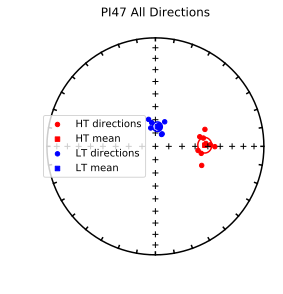

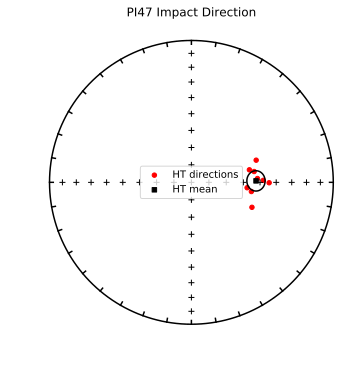

Fisher mean:  {'inc': 52.4, 'k': 90.0, 'n': 9.0, 'alpha95': 5.5, 'r': 8.9112, 'dec': 88.7}


In [7]:
PI47 = ipmag.Site('PI47',
            '../Data/magic2.5_files/Thermal/PI47')
PI47.eq_plot_everything('PI47 All Directions', clrs=('r', 'b', 'y'), size=(4,4))
PI47.eq_plot('HT','PI47 Impact Direction', 'r')
PI47_mean_data = PI47.get_fisher_mean('HT')
print('Fisher mean: ', PI47_mean_data)
site_means.loc['PI47'] = PI47.get_site_data('breccia dike matrix','HT')
#site_means

## DeI2 breccia dike

At site DeI2, the matrix of a 2 to 8 cm thick breccia dike was sampled. The matrix was composed of hematite-rich siltstone. Clasts were sub-angular to sub-rounded fine to very coarse grained sand grains, and consisted dominantly of quartz with the minor presence of red and gray lithics.

Data separated by  ['HT', 'hem', 'LT'] fits and can be accessed by <site_name>.<fit_name>
HT_mean
90.2 43.3
hem_mean
95.5 36.5
LT_mean
150.3 84.6


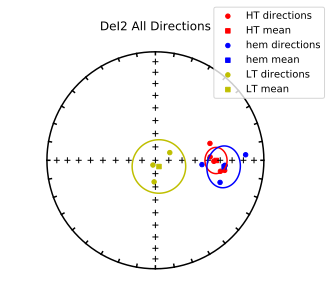

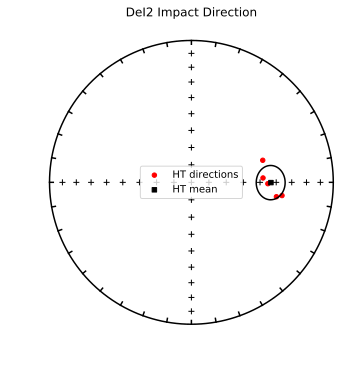

Fisher mean:  {'inc': 43.3, 'k': 73.0, 'n': 5.0, 'alpha95': 9.0, 'r': 4.9456, 'dec': 90.2}


In [8]:
DeI2 = ipmag.Site('DeI2',
            '../Data/magic2.5_files/Thermal/DeI2')
DeI2.eq_plot_everything('DeI2 All Directions', clrs=('r', 'b', 'y'), 
                        size=(4,4), loc=(0.75,0.75))
DeI2.eq_plot('HT','DeI2 Impact Direction', 'r')
DeI2_mean_data = DeI2.get_fisher_mean('HT')
print('Fisher mean: ', DeI2_mean_data)
site_means.loc['DeI2'] = DeI2.get_site_data('breccia dike matrix','HT')
#site_means

## PI2 breccia dike

Breccia dike PI2 contained clasts of amygdaloidal basalt as well as more massive mafic volcanics some with hematite alteration. The largest sampled clast was 17 x 14 cm. The matrix at this site was a deep red color, likely a consequence of interstitial hematite.

### Clasts
Paleomagnetic directions of clasts exhibit a low coercivity remanence that fails a conglomerate test and aligns well with the impact direction inferred from other breccia sites. The high coercivity components, on the other hand, are quite scattered and suggest that clasts at this site were not fully remagnetized. Unfortunately, these clast samples experienced intense gryoremanence during AF demagnetization, so a legitimate separate high coercivity component was not well isolated. Additionally, there was not enough remaining sample material for thermal demagnetization. We present the low coercivity data here as a likely partial TRM acquired during emplacement (if not a full TRM that was obscured by GRM during measurement). 

Data separated by  ['HC', 'LC'] fits and can be accessed by <site_name>.<fit_name>
HC_mean
352.7 81.9
LC_mean
77.1 69.9


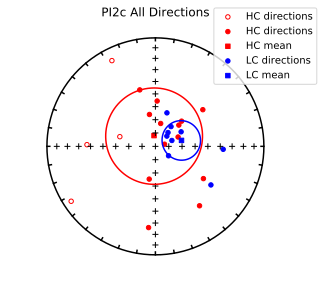

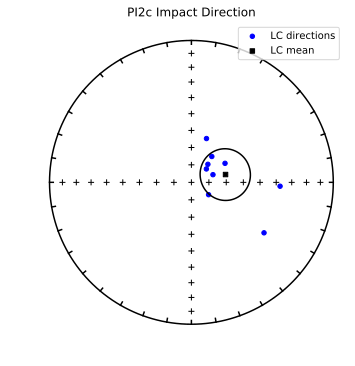

Fisher mean:  {'inc': 69.9, 'k': 13.0, 'n': 9.0, 'alpha95': 14.6, 'r': 8.3992, 'dec': 77.1}


In [9]:
PI2c = ipmag.Site('PI2c',
            '../Data/magic2.5_files/AF/PI2c')
PI2c.eq_plot_everything('PI2c All Directions',clrs=('r', 'b', 'y'), 
                        size=(4,4),loc=(0.75,0.75))
PI2c.eq_plot('LC','PI2c Impact Direction', 'b')
PI2c_mean_data = PI2c.get_fisher_mean('LC')
print('Fisher mean: ', PI2c_mean_data)
site_means.loc['PI2c'] = PI2c.get_site_data('breccia dike clasts','LC', demag_type='AF')

In [10]:
add_cong_result(PI2c.get_site_data('breccia dike clasts','HC'),'PI2c',demag_type='AF')

demag_type   n       R        Ro result 95_confidence 99_confidence
PI2c         AF  17  8.6718  6.654698   FAIL           YES           YES

### Matrix

Data separated by  ['LT', 'hem', 'HT'] fits and can be accessed by <site_name>.<fit_name>
LT_mean
352.9 71.1
hem_mean
78.7 43.7
HT_mean
79.5 47.9


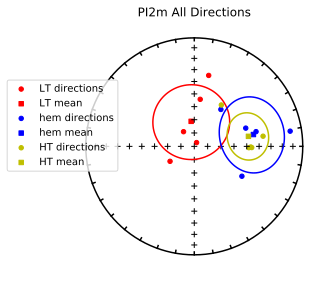

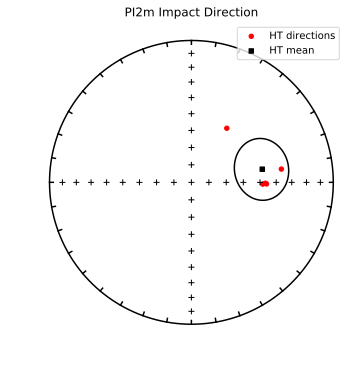

Fisher mean:  {'inc': 47.9, 'k': 22.0, 'n': 5.0, 'alpha95': 16.6, 'r': 4.8202, 'dec': 79.5}


In [11]:
PI2m = ipmag.Site('PI2m',
            '../Data/magic2.5_files/Thermal/PI2m')
PI2m.eq_plot_everything('PI2m All Directions', clrs=('r', 'b', 'y'),
                        loc=(-0.3,0.4), size=(4,4))
PI2m.eq_plot('HT','PI2m Impact Direction', 'r')
PI2m_mean_data = PI2m.get_fisher_mean('HT')
print('Fisher mean: ', PI2m_mean_data)
site_means.loc['PI2m'] = PI2m.get_site_data('breccia dike matrix','HT')

## PI15 breccia dike

At site PI15, the matrix of a 20 cm thick breccia dike was sampled. The matrix is green/grey and contains small (mm scale) clasts. 

Data separated by  ['LT', 'HT', 'hem'] fits and can be accessed by <site_name>.<fit_name>
LT_mean
354.2 75.0
HT_mean
81.7 47.8
hem_mean
148.2 -29.8


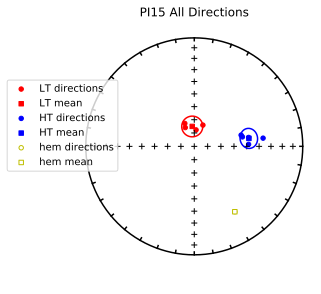

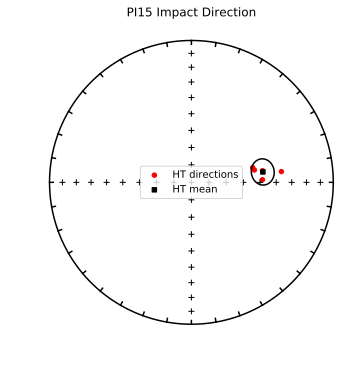

Fisher mean:  {'inc': 47.8, 'k': 119.0, 'n': 5.0, 'alpha95': 7.0, 'r': 4.9664, 'dec': 81.7}


In [12]:
PI15 = ipmag.Site('PI15',
            '../Data/magic2.5_files/Thermal/PI15')
PI15.eq_plot_everything('PI15 All Directions', clrs=('r', 'b', 'y'),
                        size=(4,4),loc=(-0.3,0.4))
PI15.eq_plot('HT','PI15 Impact Direction' ,'r')
PI15_mean_data = PI15.get_fisher_mean('HT')
print('Fisher mean: ', PI15_mean_data)
site_means.loc['PI15'] = PI15.get_site_data('breccia dike matrix','HT')

## PI16 breccia dike

At site PI16, 25 clasts of Archean schist were sampled within an up to 80 cm thick breccia dike.

Data separated by  ['HT', 'LT'] fits and can be accessed by <site_name>.<fit_name>
HT_mean
84.1 53.5
LT_mean
57.8 76.5


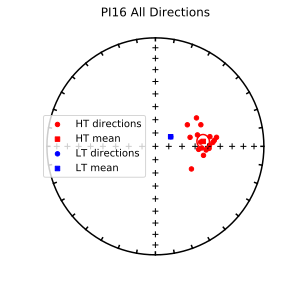

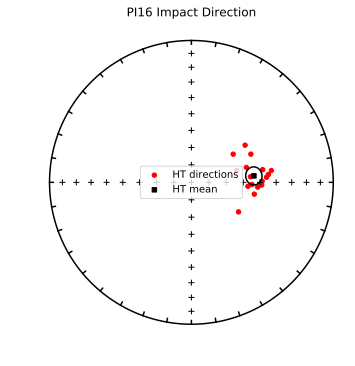

Fisher mean:  {'inc': 53.5, 'k': 55.0, 'n': 17.0, 'alpha95': 4.9, 'r': 16.7069, 'dec': 84.1}


In [13]:
PI16 = ipmag.Site('PI16',
            '../Data/magic2.5_files/Thermal/PI16')
PI16.eq_plot_everything('PI16 All Directions', clrs=('r', 'b', 'y'),size=(4,4))
PI16.eq_plot('HT','PI16 Impact Direction','r')
PI16_mean_data = PI16.get_fisher_mean('HT')
print('Fisher mean: ', PI16_mean_data)
site_means.loc['PI16'] = PI16.get_site_data('breccia dike clasts','HT')

In [14]:
add_cong_result(PI16.get_site_data('clasts','HT'),'PI16')

demag_type   n        R        Ro result 95_confidence 99_confidence
PI2c         AF  17   8.6718  6.654698   FAIL           YES           YES
PI16    Thermal  17  16.7069  6.654698   FAIL           YES           YES

## PI22 breccia dike

At site PI22, 15 clasts comprised of felsic porphyry (with the exception of samples PI22-1 and PI22-2 [felsic metamorphic schists] and PI22-3 [intermediate metavolcanic]) were sampled within an ~10 m thick breccia dike. Clasts are subangular, and sampled clasts range in size from 9 to 40 cm in diameter.

Data separated by  ['LT', 'HT', 'hem', 'MT'] fits and can be accessed by <site_name>.<fit_name>


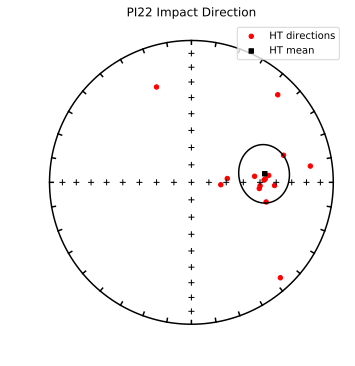

Fisher mean:  {'inc': 46.8, 'k': 7.0, 'n': 15.0, 'alpha95': 15.6, 'r': 12.9965, 'dec': 83.3}


In [19]:
PI22 = ipmag.Site('PI22',
            '../Data/magic2.5_files/Thermal/PI22')
# PI22.eq_plot_everything('PI22 All Directions', clrs=('r', 'b', 'g', 'y'),size=(4,4))
PI22.eq_plot('HT','PI22 Impact Direction', 'r')
PI22_mean_data = PI22.get_fisher_mean('HT')
print('Fisher mean: ', PI22_mean_data)
site_means.loc['PI22'] = PI22.get_site_data('breccia dike clasts','HT')
#site_means

In [20]:
add_cong_result(PI22.get_site_data('breccia dike clasts','HT'),'PI22')

demag_type   n        R        Ro result 95_confidence 99_confidence
PI2c         AF  17   8.6718  6.654698   FAIL           YES           YES
PI16    Thermal  17  16.7069  6.654698   FAIL           YES           YES
PI22    Thermal  15  12.9965  6.251000   FAIL           YES           YES

## PI24 breccia dike

At site PI24, 8 clasts comprised of Archean felsic intrusive rock (PI24c-1 through PI24c-8) were sampled from a 1.4 m wide breccia dike. Clasts are subangular and range from granule size to 50 cm in length. Multiple clasts contain shatter cones, indicating emplacement subsequent to the passing of the shock wave. The breccia matrix is gray/green. PI24m-9 through PI24m-14 are matrix samples.

### Clasts

Data separated by  ['LT', 'HT', 'hem'] fits and can be accessed by <site_name>.<fit_name>
LT_mean
355.3 64.2
HT_mean
92.8 50.8
hem_mean
156.7 44.6


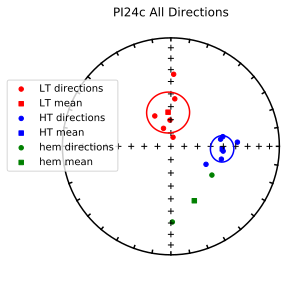

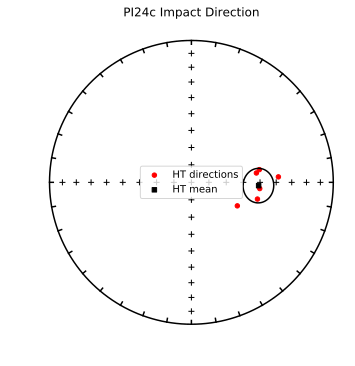

Fisher mean:  {'inc': 50.8, 'k': 53.0, 'n': 6.0, 'alpha95': 9.3, 'r': 5.9056, 'dec': 92.8}


In [22]:
PI24c = ipmag.Site('PI24c',
            '../Data/magic2.5_files/Thermal/PI24c')
PI24c.eq_plot_everything('PI24c All Directions', clrs=('r', 'b', 'g'),
                        loc=(-0.2,0.4), size=(4,4))
PI24c.eq_plot('HT','PI24c Impact Direction', 'r')
PI24c_mean_data = PI24c.get_fisher_mean('HT')
print('Fisher mean: ', PI24c_mean_data)
site_means.loc['PI24c'] = PI24c.get_site_data('breccia dike clasts','HT')

In [23]:
add_cong_result(PI24c.get_site_data('breccia dike clasts','HT'),'PI24c')

demag_type   n        R        Ro result 95_confidence 99_confidence
PI2c          AF  17   8.6718  6.654698   FAIL           YES           YES
PI16     Thermal  17  16.7069  6.654698   FAIL           YES           YES
PI22     Thermal  15  12.9965  6.251000   FAIL           YES           YES
PI24c    Thermal   6   5.9056  3.953479   FAIL           YES           YES

### Matrix

Data separated by  ['LT', 'HT'] fits and can be accessed by <site_name>.<fit_name>
LT_mean
7.2 69.6
HT_mean
86.0 46.2


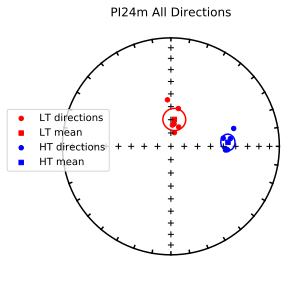

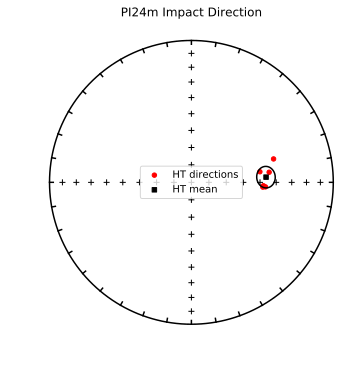

Fisher mean:  {'inc': 46.2, 'k': 140.0, 'n': 6.0, 'alpha95': 5.7, 'r': 5.9644, 'dec': 86.0}


In [24]:
PI24m = ipmag.Site('PI24m',
            '../Data/magic2.5_files/Thermal/PI24m')
PI24m.eq_plot_everything('PI24m All Directions', clrs=('r', 'b', 'g'),
                        loc=(-0.2,0.4), size=(4,4))
PI24m.eq_plot('HT','PI24m Impact Direction', 'r')
PI24m_mean_data = PI24m.get_fisher_mean('HT')
print('Fisher mean: ', PI24m_mean_data)
site_means.loc['PI24m'] = PI24m.get_site_data('breccia dike matrix','HT')

## PI26 breccia dike

At site PI26, 8 samples of matrix were collected from a breccia dike network intruding felsic Archean schist. The multiple diverging branches of the breccia dike are up to 40 cm thick. Branches thin to mm-scale thickness farther away from the locus of the breccia network. The breccia dike is clast-rich, but matrix-supported. Clasts are angular to subangular, granule to pebble size, and are comprised of a variety of metamorphic lithologies and some diabase. Some clasts are of the same lithology as the adjacent host rock, but others are not from the immediate locale. The breccia dike matrix is fine to very fine grained and its dark red coloration due to the presence of interstitial hematite.

Data separated by  ['LT', 'HT'] fits and can be accessed by <site_name>.<fit_name>
LT_mean
20.5 68.8
HT_mean
83.2 52.5


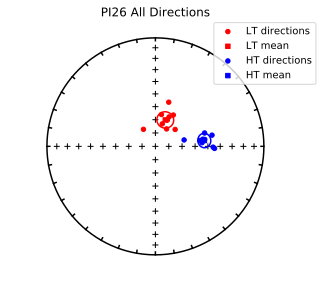

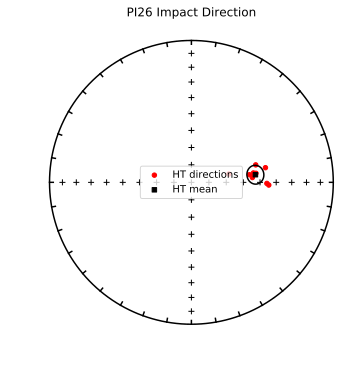

Fisher mean:  {'inc': 52.5, 'k': 103.0, 'n': 9.0, 'alpha95': 5.1, 'r': 8.922, 'dec': 83.2}


In [25]:
PI26 = ipmag.Site('PI26',
            '../Data/magic2.5_files/Thermal/PI26')
PI26.eq_plot_everything('PI26 All Directions', clrs=('r', 'b', 'g'),
                        loc=(0.75,0.75), size=(4,4))
PI26.eq_plot('HT','PI26 Impact Direction','r')
PI26_mean_data = PI26.get_fisher_mean('HT')
print('Fisher mean: ', PI26_mean_data)
site_means.loc['PI26'] = PI26.get_site_data('breccia dike matrix','HT')
#site_means

## PI31 breccia dike

At the site PI31 breccia dike, 20 clasts comprised of felsic, mafic, and K-feldspar porphyry schist were sampled from a >3 m breccia dike. The matrix of the breccia is a deep red color.

Data separated by  ['LT', 'HT', 'MT'] fits and can be accessed by <site_name>.<fit_name>
LT_mean
356.6 67.8
HT_mean
89.6 31.0
MT_mean
89.4 49.0


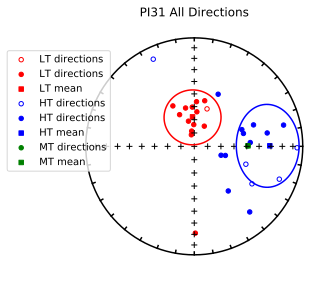

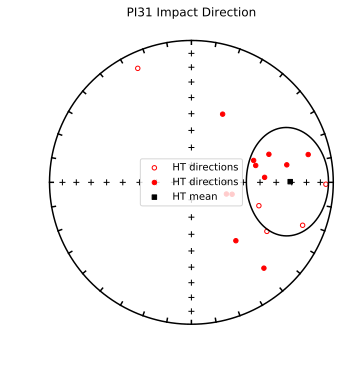

Fisher mean:  {'inc': 31.0, 'k': 3.0, 'n': 16.0, 'alpha95': 27.2, 'r': 10.6733, 'dec': 89.6}


In [26]:
PI31 = ipmag.Site('PI31',
            '../Data/magic2.5_files/Thermal/PI31')
PI31.eq_plot_everything('PI31 All Directions',clrs=('r', 'b', 'g'),
                        loc=(-0.3,0.4),size=(4,4))
PI31.eq_plot('HT','PI31 Impact Direction','r')
PI31_mean_data = PI31.get_fisher_mean('HT')
print('Fisher mean: ', PI31_mean_data)
site_means.loc['PI31'] = PI31.get_site_data('breccia dike clasts','HT')
#site_means

In [27]:
add_cong_result(PI31.get_site_data('breccia dike clasts','HT'),'PI31')

demag_type   n        R        Ro result 95_confidence 99_confidence
PI2c          AF  17   8.6718  6.654698   FAIL           YES           YES
PI16     Thermal  17  16.7069  6.654698   FAIL           YES           YES
PI22     Thermal  15  12.9965  6.251000   FAIL           YES           YES
PI24c    Thermal   6   5.9056  3.953479   FAIL           YES           YES
PI31     Thermal  16  10.6733  6.456005   FAIL           YES           YES

## PI44 breccia dike

At site PI44, 13 samples of matrix were collected from a ~10-40 cm thick breccia dike. The breccia cross-cuts a Keweenawan diabase dike and an Archean meta-intrusive (?) schist. Clasts are dominantly pebble size, but can be as large as 25 cm in length. Breccia matrix is fine-grained and the collected specimens include small, granule-sized clasts.

Data separated by  ['LT', 'HT'] fits and can be accessed by <site_name>.<fit_name>
LT_mean
4.6 73.6
HT_mean
86.5 48.7


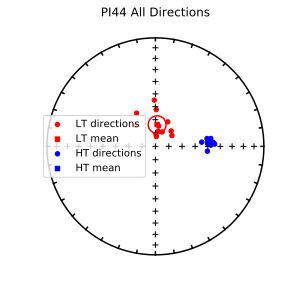

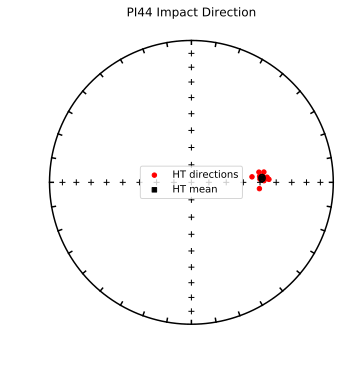

Fisher mean:  {'inc': 48.7, 'k': 499.0, 'n': 12.0, 'alpha95': 1.9, 'r': 11.978, 'dec': 86.5}


In [28]:
PI44 = ipmag.Site('PI44',
            '../Data/magic2.5_files/Thermal/PI44')
PI44.eq_plot_everything('PI44 All Directions',clrs=('r', 'b', 'g'),size=(4,4))
PI44.eq_plot('HT','PI44 Impact Direction','r')
PI44_mean_data = PI44.get_fisher_mean('HT')
print('Fisher mean: ', PI44_mean_data)
site_means.loc['PI44'] = PI44.get_site_data('breccia dike matrix','HT')
#site_means

## PI46 breccia dike

At site PI46, 11 samples of matrix were collected from a 25 cm thick breccia dike. The breccia dike contains granule to small-sized clasts (the largest clast is 15 cm across, although the majority are smaller). Breccia matrix is green/gray and very fine-grained. 

Data separated by  ['HT'] fits and can be accessed by <site_name>.<fit_name>
HT_mean
94.2 49.0


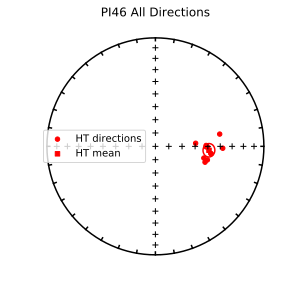

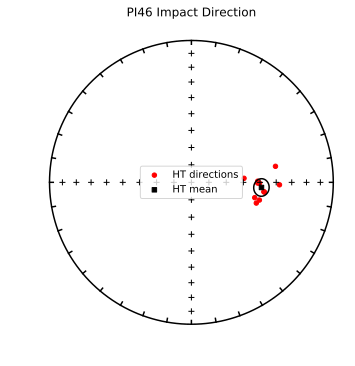

Fisher mean:  {'inc': 49.0, 'k': 96.0, 'n': 11.0, 'alpha95': 4.7, 'r': 10.8956, 'dec': 94.2}


In [29]:
PI46 = ipmag.Site('PI46',
            '../Data/magic2.5_files/Thermal/PI46')
PI46.eq_plot_everything('PI46 All Directions',clrs=('r', 'b', 'g'), size=(4,4))
PI46.eq_plot('HT','PI46 Impact Direction','r')
PI46_mean_data = PI46.get_fisher_mean('HT')
print('Fisher mean: ', PI46_mean_data)
site_means.loc['PI46'] = PI46.get_site_data('breccia dike matrix','HT')

# Breccia dike host rock

Here we present the results of baked contact tests for one breccia dike intrusion into a stack of basalt flows (host rock sites PI32, PI33, PI34) and three breccia dike intrusions into Archean schist (host rock sites PI16, PI22, PI24). These results support the hypothesis that breccia dikes were emplaced at high temperatures, which imparted partial overprints to host rock removed at lower (higher) temperatures at greater (lesser) distance from the nearest breccia dike contact. Moreover, the general observation of partial overprinting of host rock (pTRM) contrasts with the full overprinting of daughter clasts of similar lithology within breccia dikes and therefore supports the hypothesis that breccia dike clasts record a TRM.

The maximum unblocking temperatures of magnetic components have been compiled for both breccia dike clasts and host rock data. These can be found in the *Data* repository and are uploaded below.

In [30]:
# upload unblocking temperature data for host rock
host_bct = pd.read_csv('../Data/baked_contact_analysis/baked_contact.csv')
# upload unblocking temperature data for breccia dike clasts
breccia_bct = pd.read_csv('../Data/baked_contact_analysis/clasts_max_temp.csv')
breccia_bct.head()

er_sample_name  measurement_step_max specimen_comp_name
0        PI16-10                   560                 HT
1        PI16-11                   580                 HT
2        PI16-12                   525                 HT
3        PI16-13                   550                 HT
4        PI16-14                   570                 HT

In [31]:
host_bct.head()

sample  max_temp fit  distance_m  dis_norm
0  PI24-16a       375  MT        0.86  0.330769
1  PI24-17a       400  MT        1.13  0.434615
2  PI24-18a       500  MT        0.56  0.215385
3  PI24-20a       570  MT        0.06  0.023077
4  PI24-21a       560  MT        0.50  0.192308

We first initialize the plot we will use to visualize the baked contact test and compare the unblocking temperatures to distance from the nearest breccia dike. We start by plotting the range of temperatures at which the full overprints in breccia dike clasts were removed from clasts throughout the sampled breccia dieks. This range will be used as a helpful visual comparison in the baked contact tests below. We generalize the following code within a function, **BCT**, below.

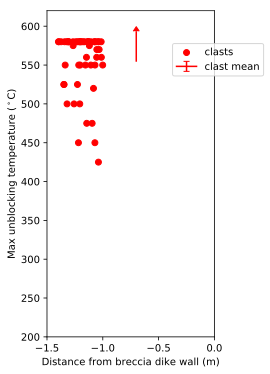

In [32]:
def BCT(display_breccia=True, breccia_site = None, display_host=True, 
        host_name=None, one_error=False, error_x=5, figure_size = (8,6),
        fillna=False, na_value=None, bin_number = 3, no_new_fig=False):
    
    if display_host==True:
        criterion = host_bct['sample'].map(lambda x: x.startswith(host_name))
        host = host_bct[criterion]
        host.reset_index(inplace=True, drop=True)
        if fillna==True:
            host = host.fillna(na_value)
    if no_new_fig is False:
        plt.figure(figsize=figure_size)
    
    if breccia_site is not None:
        criterion = breccia_bct['er_sample_name'].map(lambda x: x.startswith(breccia_site))
        breccia_data = breccia_bct[criterion]
        breccia_data.reset_index(inplace=True, drop=True)
    else:
        breccia_data = breccia_bct
    
    if display_breccia==True:
        data_plt_x = []
        data_plt_y = []
        for i in range(len(breccia_data)):
            rand_x = 0.4*np.random.random_sample()-1.4
            data_plt_x.append(rand_x)
            data_plt_y.append(breccia_data.measurement_step_max[i])
            if i==0:
                plt.scatter(rand_x,breccia_data.measurement_step_max[i],c='r',label="clasts")
            else:
                plt.scatter(rand_x,breccia_data.measurement_step_max[i],c='r')
        breccia_mean_temp = np.mean(data_plt_y)
        breccia_std = np.std(data_plt_y)
        plt.errorbar(-0.7,breccia_mean_temp, yerr=breccia_std,label='clast mean', lolims=True, color='r')

    if display_host==True:
        data_plt_x = []
        data_plt_y = []

        for i in range(len(host)):
            data_plt_x.append(host.distance_m[i])
            data_plt_y.append(host.max_temp[i])
            if i==0:
                plt.scatter(host.distance_m[i],host.max_temp[i],c='b',label="host")
            else:
                plt.scatter(host.distance_m[i],host.max_temp[i],c='b')
        x = np.array(data_plt_x)
        y = np.array(data_plt_y)
        if one_error==False:
            nbins = bin_number
            n, a = np.histogram(x, bins=nbins)
            sy, b = np.histogram(x, bins=nbins, weights=y)
            sy2, c = np.histogram(x, bins=nbins, weights=y*y)
            mean = sy / n
            std = np.sqrt(sy2/n - mean*mean)
            plt.errorbar((a[1:] + b[:-1])/2, mean, yerr=std, fmt='b-',label='host mean')
        else:
            plt.errorbar(error_x,np.mean(y), yerr=np.std(y), fmt='b-',label='host mean')

BCT(display_breccia=True, display_host=False, figure_size=(3,6))
plt.legend(loc=(0.75,0.8))
plt.xlim(-1.5, 0)
plt.ylim(200,620)
plt.xticks(np.arange(-1.5,0.5, .5))
plt.xlabel('Distance from breccia dike wall (m)')
plt.ylabel('Max unblocking temperature ($^\circ$C)')
plt.savefig('Breccia_Dike_data2_72_0.pdf')
plt.show()

## PI32, PI33 and PI34 host rock sites

In a stratigraphic section of Keweenawan lava flows, sites PI32 and PI33 are from flows that are ~22 meters and ~18 meters respectively away from a ~5 meter thick breccia dike. PI34 is from the flow that is in contact with that ~5 meter breccia dike with samples within a dike width's distance. PI32 and PI33 have partial impact direction overprints removed at ~275ºC while PI34 is fully overprinted in the impact direction. We interpret these PI34 results to indicate that the complete overprint of the samples is associated with localized heating due to emplacement of the hot breccia dike while the partial overprint on PI32 and PI33 is due to regionally elevated temperatures. These results constitute a positive test of the hypothesis that breccia dikes were emplaced hot into cooler rock and subsequently conductively cooled. 

### PI32

Data separated by  ['MT', 'HT', 'hem', 'LT'] fits and can be accessed by <site_name>.<fit_name>
MT_mean
72.2 47.1
HT_mean
179.3 -20.2
hem_mean
196.4 -35.4
LT_mean
317.6 77.1


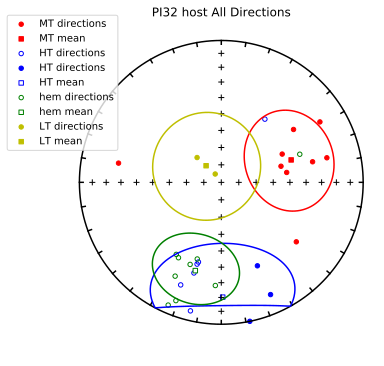

In [33]:
PI32_host = ipmag.Site('PI32 host',
            '../Data/magic2.5_files/Thermal/Host_rock/PI32/')
PI32_host.eq_plot_everything('PI32 host All Directions',clrs=('r','b','g','y'),loc=(-0.2,0.6))

### PI33

Data separated by  ['MT', 'HT', 'hem'] fits and can be accessed by <site_name>.<fit_name>
MT_mean
75.2 34.2
HT_mean
166.7 -25.0
hem_mean
181.4 -37.7


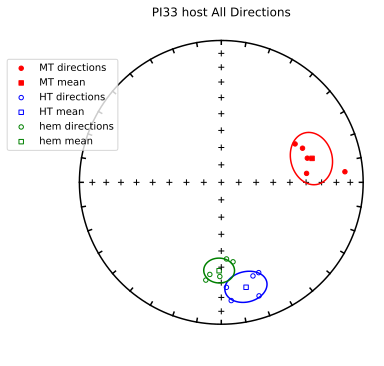

In [34]:
PI33_host = ipmag.Site('PI33 host',
            '../Data/magic2.5_files/Thermal/Host_rock/PI33/')
PI33_host.eq_plot_everything('PI33 host All Directions',clrs=('r','b','g','y'),loc=(-0.2,0.6))

### PI34

Data separated by  ['LT', 'HT', 'MT'] fits and can be accessed by <site_name>.<fit_name>
LT_mean
13.4 78.8
HT_mean
101.2 55.4
MT_mean
66.7 72.9


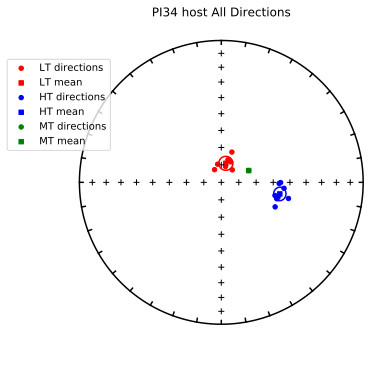

In [36]:
PI34_host = ipmag.Site('PI34 host',
            '../Data/magic2.5_files/Thermal/Host_rock/PI34/')
PI34_host.eq_plot_everything('PI34 host All Directions',clrs=('r','b','g','y'),loc=(-0.2,0.6))

### Baked contact test of basalt flow host rock

Below we plot the maximum unblocking temperature of impact-direction overprints within basalt host rock against distance from breccia dike which is within flow PI34.

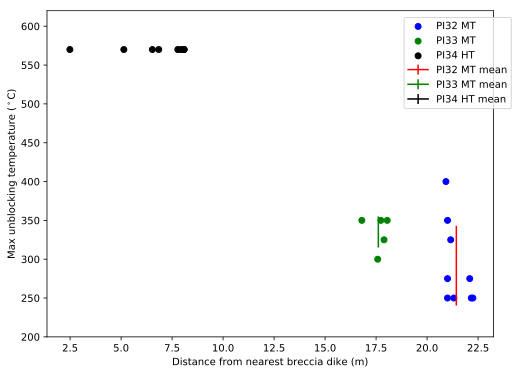

In [37]:
BCT(display_breccia=False, display_host=False)
flow_clr_dict = {'PI32':('b','r-', 'PI32 MT'), 
                 'PI33':('g', 'g-','PI33 MT'), 
                 'PI34':('k', 'k-','PI34 HT')}
for flow in flow_clr_dict.keys():
    j=0
    criterion = host_bct['sample'].map(lambda x: x.startswith(flow))
    host = host_bct[criterion]
    host.reset_index(inplace=True, drop=True)

    data_plt_x = []
    data_plt_y = []

    for i in range(len(host)):
        data_plt_x.append(host.distance_m[i])
        data_plt_y.append(host.max_temp[i])
        if j==0:
            plt.scatter(host.distance_m[i],host.max_temp[i],
                        c=flow_clr_dict[flow][0],
                        label=flow_clr_dict[flow][2])
        else:
            plt.scatter(host.distance_m[i],host.max_temp[i],
                        c=flow_clr_dict[flow][0])
        j=1
    x = np.array(data_plt_x)
    y = np.array(data_plt_y)
    if flow == 'PI34':
        plt.errorbar(4,np.mean(y), yerr=np.std(y),
                     fmt=flow_clr_dict[flow][1],
                     label=flow_clr_dict[flow][2]+' mean')
    else:
        plt.errorbar(np.mean(x),np.mean(y), yerr=np.std(y),
                     fmt=flow_clr_dict[flow][1],
                     label=flow_clr_dict[flow][2] +' mean')
    
plt.legend(loc=(0.8,0.7))
plt.ylim(200,620)
plt.xlabel('Distance from nearest breccia dike (m)')
plt.ylabel('Max unblocking temperature ($^\circ$C)')
plt.savefig('baked_contact_test_flows.pdf')
plt.show()

## Archean schist

Here we present paleomagnetic data of breccia dike host rock (Archean schist) obtained from three breccia dike sample sites. In addition to Archean schist being poor magnetic recorders with the potential to have pTRM tails that cause remanence to be blocked at high temperatures than the rocks were heated and to have weak pre-impact remanence, the occasional high variability of unblocking temperatures may be due to the fact that the distance from the nearest breccia dike assigned to each data point is often unclear. Breccia dike networks are complicated and may extend closer to our host rock sampling sites than we are able to observe, or that initial breccia dike/host rock contacts have since been eroded. These factors are likely responsible for the outliers in the data shown below. Nevertheless, a relationship between the magnetizations of breccia dike clasts (plotted in red at a negative distance) and their parent (host) rocks can be established from the data. The impact direction magnetizations of host rock are consistently removed at temperatures below 580&deg; C when sampled at appreciable distance from a breccia dike intrusion, indicating that the impact direction in host rocks is a partial thermal overprint (pTRM) as opposed to the full TRM acquired by breccia dike clasts.

### PI16 host rock

At site PI16, 5 samples of mafic to intermediate Archean greenschist were collected at a minimum distance of 8 m from the nearest exposed breccia dike, which was approximately 0.4 meters thick. The demagnetization data reveal that these samples have a present local field overprint, a partial impact direction overprint and a poorly resolved direction held at unblocking temperatures above those that remove the impact direction. These results supports the interpretation that heating to temperatures >580ºC was localized to the breccia dikes and their immediate vicinity.

Data separated by  ['PLF', 'MT', 'HT', 'hem'] fits and can be accessed by <site_name>.<fit_name>
PLF_mean
341.5 75.0
MT_mean
73.0 59.5
HT_mean
96.1 27.9
hem_mean
55.1 43.2


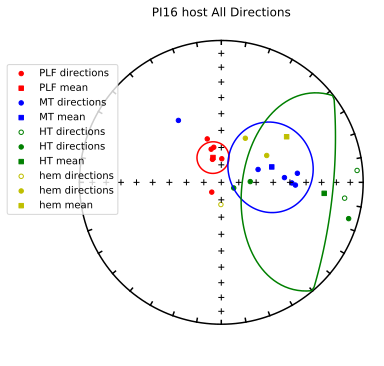

In [38]:
PI16_host = ipmag.Site('PI16',
            '../Data/magic2.5_files/Thermal/Host_rock/PI16H/')
PI16_host.eq_plot_everything('PI16 host All Directions', clrs=('r','b','g','y'), loc=(-0.2,0.4))

Among the resolvable paleomagnetic directions of breccia dike host rock presented above, the component labeled **MT** (mid-temperatures) is most representative of the Slate Islands impact direction recorded in breccia dikes. Remanence is present after that overprint is removed, but the direction is poorly resolved.

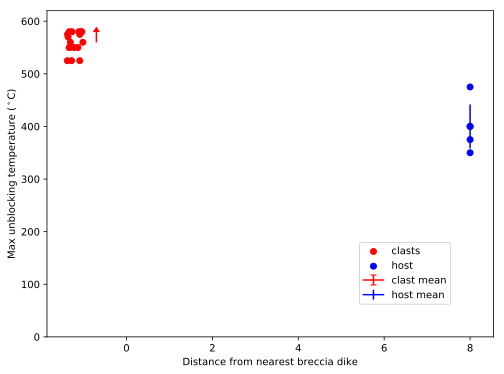

In [39]:
BCT(host_name = 'PI16', breccia_site='PI16', one_error=True,error_x=8)
plt.legend(loc=(0.7,0.1))
plt.ylim(0,620)
plt.xlabel('Distance from nearest breccia dike')
plt.ylabel('Max unblocking temperature ($^\circ$C)')
plt.show()

### PI22 host rock

At breccia dike site PI22, 16 samples of Archean mafic schist host rock were collected at variable distances (3 cm to >5 m) from the nearest observable breccia dike contact. The thickness of breccia dike PI22 varied from 0.75 - 1.3 meters in the vicinity of the baked contact test.

Data separated by  ['PLF', 'MT', 'HT'] fits and can be accessed by <site_name>.<fit_name>
PLF_mean
6.4 71.3
MT_mean
81.6 55.7
HT_mean
246.4 54.9


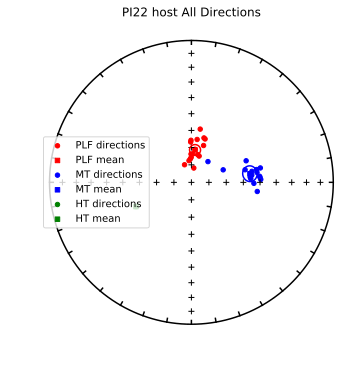

In [40]:
PI22_host = ipmag.Site('PI22H',
            '../Data/magic2.5_files/Thermal/Host_rock/PI22H/')
PI22_host.eq_plot_everything('PI22 host All Directions',clrs=('r','b','g','y'))

Among the resolvable paleomagnetic directions of breccia dike host rock presented above, the component labeled **MT** (mid-temperatures) is most representative of the Slate Islands impact direction recorded in breccia dikes.

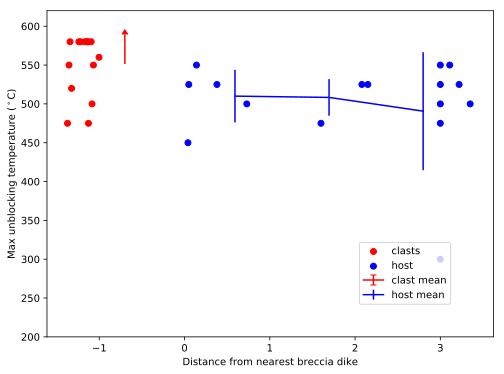

In [41]:
BCT(host_name='PI22', breccia_site='PI22', fillna=True, na_value=3)
plt.legend(loc=(0.7,0.1))
plt.ylim(200,620)
plt.xlabel('Distance from nearest breccia dike')
plt.ylabel('Max unblocking temperature ($^\circ$C)')
plt.show()

### PI24 host rock

At breccia dike site PI24, 15 samples of K-feldspar porphyry host rock were sampled at variable distances (4 cm to >3 m) from the closest observable breccia dike contact. The photo below shows the sharp contact (outlined in yellow) of the breccia dike intrusion (top) with the host rock (bottom) that was amenable to a baked contact test. The thickness of breccia dike PI24 varied from 2.2 - 2.6 meters in the vicinity of the baked contact test.

Data separated by  ['MT', 'PLF', 'HT'] fits and can be accessed by <site_name>.<fit_name>
MT_mean
76.9 62.2
PLF_mean
347.6 78.4
HT_mean
324.4 58.9


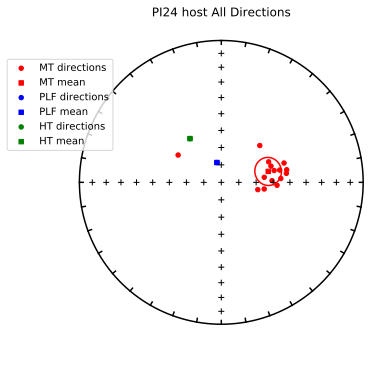

In [42]:
PI24_host = ipmag.Site('PI24 host',
            '../Data/magic2.5_files/Thermal/Host_rock/PI24H/')
PI24_host.eq_plot_everything('PI24 host All Directions',clrs=('r','b','g','y'),loc=(-0.2,0.6))

Among the resolvable paleomagnetic directions of breccia dike host rock presented above, the component labeled **MT** (mid-temperatures) is most representative of the Slate Islands impact direction recorded in breccia dikes.

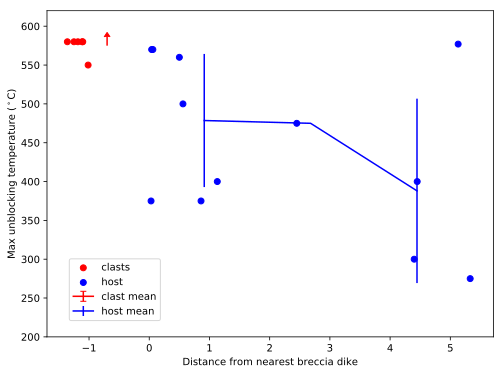

In [43]:
BCT(host_name='PI24', breccia_site='PI24')
plt.legend(loc=(0.05,0.05))
plt.ylim(200,620)
plt.xlabel('Distance from nearest breccia dike')
plt.ylabel('Max unblocking temperature ($^\circ$C)')
plt.show()

[Go to top](#Introduction)

# Conglomerate Test Results

All breccia dike sites where clasts were sampled failed a paleomagnetic conglomerate test at the 99% confidence level (see table below).

In [44]:
# cong_test_all_data.to_latex('latex_tables/cong_test_all_data.txt')
cong_test_all_data

demag_type   n        R        Ro result 95_confidence 99_confidence
PI2c          AF  17   8.6718  6.654698   FAIL           YES           YES
PI16     Thermal  17  16.7069  6.654698   FAIL           YES           YES
PI22     Thermal  15  12.9965  6.251000   FAIL           YES           YES
PI24c    Thermal   6   5.9056  3.953479   FAIL           YES           YES
PI31     Thermal  16  10.6733  6.456005   FAIL           YES           YES

[Go to top](#Introduction)

# Site Means

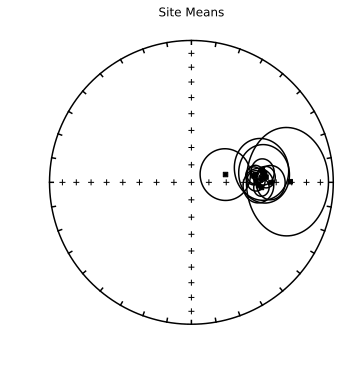

In [52]:
fignum = 10
plt.figure(num=fignum,figsize=(5,5),dpi=200)
ipmag.plot_net(fignum)    
for n in range(0,len(site_means)):
    ipmag.plot_di_mean(site_means['dec'][n],
                      site_means['inc'][n],
                      site_means['a_95'][n],
                      color='k',marker='s')
plt.title('Site Means')
# plt.savefig('Code_Output/site_means_equal-area_no_outliers.svg')
plt.show()

A couple of the site means have quite large $\alpha_{95}$ uncertainities and although they correspond with the mean population, we consider it best to filter them out of the calculation of an overall mean of the sites. Let's only include sites with $\alpha_{95}$<16 in the calculation of the overall mean.

In [53]:
site_means_dec=[]
site_means_inc=[]
site_means_directions=[]

for n in list(site_means.index): 
    if site_means.loc[n]['a_95'] < 16.0:
        dec = site_means.loc[n]['dec']
        inc = site_means.loc[n]['inc']
        site_means_dec.append(dec)
        site_means_inc.append(inc)
        site_means_directions.append([dec,inc,1.])
        
site_means_mean = pmag.fisher_mean(site_means_directions)
site_means_mean

{'alpha95': 4.2789496500181077,
 'csd': 7.5590170029636949,
 'dec': 86.592742644284016,
 'inc': 51.049573957404384,
 'k': 114.82577711347182,
 'n': 11,
 'r': 10.912911540845764}

The sites (without their $\alpha_{95}$ errors) and the overall mean of the sites with its $\alpha_{95}$ error ellipse are plotted below.

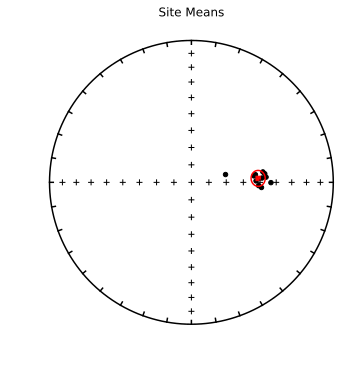

In [55]:
fignum = 11
plt.figure(num=fignum,figsize=(5,5),dpi=200)
ipmag.plot_net(fignum)
ipmag.plot_di(site_means_dec, site_means_inc)
ipmag.plot_di_mean(site_means_mean['dec'],
                  site_means_mean['inc'],
                  site_means_mean["alpha95"],
                  color='r',marker='s')
plt.title('Site Means')
# plt.savefig('Code_Output/site_means_equal-area.svg')
plt.show()

[Go to top](#Introduction)

# Clasts/Matrix Comparison and Calculation of Overall Mean

Here we compile the means of both clast and matrix sample sites and show that they share a common mean. 

## Site Means (clasts only)

In [56]:
site_means_clasts = site_means[(site_means['site_type'] == 'breccia dike clasts')]
# site_means_clasts.to_latex('latex_tables/site_means_clasts.txt')
site_means_clasts

site_type  site_lat  site_lon demag_type   dec   inc  a_95  \
PI2c   breccia dike clasts      48.6     272.9         AF  77.1  69.9  14.6   
PI16   breccia dike clasts      48.7     273.0    Thermal  84.1  53.5   4.9   
PI22   breccia dike clasts      48.7     273.0    Thermal  83.3  46.8  15.6   
PI24c  breccia dike clasts      48.7     273.0    Thermal  92.8  50.8   9.3   
PI31   breccia dike clasts      48.6     273.0    Thermal  89.6  31.0  27.2   

        n  kappa        R cong_test_result  
PI2c    9   13.0   8.3992             None  
PI16   17   55.0  16.7069             None  
PI22   15    7.0  12.9965             None  
PI24c   6   53.0   5.9056             None  
PI31   16    3.0  10.6733             None

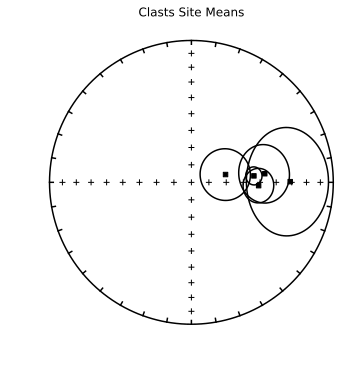

In [57]:
fignum = 13
plt.figure(num=fignum,figsize=(5,5),dpi=200)
ipmag.plot_net(fignum)    
for n in list(site_means_clasts.index):
    ipmag.plot_di_mean(site_means_clasts.loc[n]['dec'],
                      site_means_clasts.loc[n]['inc'],
                      site_means_clasts.loc[n]['a_95'],
                      color='k',marker='s')
plt.title('Clasts Site Means')
# plt.savefig('Code_Output/site_means_clasts_equal-area_no_outliers.svg')
plt.show()

Let's restrict the calculation of the overall mean to sites with $\alpha_{95}$<16.

In [58]:
site_means_clasts_dec=[]
site_means_clasts_inc=[]
site_means_clasts_directions=[]

for n in list(site_means_clasts.index): 
    if site_means_clasts.loc[n]['a_95']<16:
        dec = site_means_clasts.loc[n]['dec']
        inc = site_means_clasts.loc[n]['inc']
        site_means_clasts_dec.append(dec)
        site_means_clasts_inc.append(inc)
        site_means_clasts_directions.append([dec,inc,1.])
        
site_means_clasts_mean = pmag.fisher_mean(site_means_clasts_directions)
site_means_clasts_mean

{'alpha95': 12.227681675928041,
 'csd': 10.688665779374091,
 'dec': 85.226853841210229,
 'inc': 55.331533387344237,
 'k': 57.427914197308326,
 'n': 4,
 'r': 3.9477605961851108}

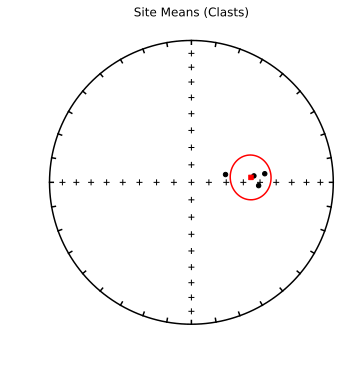

In [59]:
fignum = 14
plt.figure(num=fignum,figsize=(5,5),dpi=200)
ipmag.plot_net(fignum)
ipmag.plot_di(site_means_clasts_dec, site_means_clasts_inc)
ipmag.plot_di_mean(site_means_clasts_mean['dec'],
                  site_means_clasts_mean['inc'],
                  site_means_clasts_mean["alpha95"],
                  color='r',marker='s')
plt.title('Site Means (Clasts)')
# plt.savefig('Code_Output/site_means_clasts_equal-area.svg')
plt.show()

## Site Means (matrix only)

In [60]:
site_means_matrix = site_means[(site_means['site_type'] == 'breccia dike matrix')]
# site_means_matrix.to_latex('latex_tables/site_means_matrix.txt')
site_means_matrix

site_type  site_lat  site_lon demag_type   dec   inc  a_95  \
PI47   breccia dike matrix      48.7     -87.0    Thermal  88.7  52.4   5.5   
DeI2   breccia dike matrix      48.7     273.0    Thermal  90.2  43.3   9.0   
PI2m   breccia dike matrix      48.6     272.9    Thermal  79.5  47.9  16.6   
PI15   breccia dike matrix      48.6     273.0    Thermal  81.7  47.8   7.0   
PI24m  breccia dike matrix      48.7     273.0    Thermal  86.0  46.2   5.7   
PI26   breccia dike matrix      48.6     273.0    Thermal  83.2  52.5   5.1   
PI44   breccia dike matrix      48.7     272.9    Thermal  86.5  48.7   1.9   
PI46   breccia dike matrix      48.7     273.0    Thermal  94.2  49.0   4.7   

        n  kappa        R cong_test_result  
PI47    9   90.0   8.9112             None  
DeI2    5   73.0   4.9456             None  
PI2m    5   22.0   4.8202             None  
PI15    5  119.0   4.9664             None  
PI24m   6  140.0   5.9644             None  
PI26    9  103.0   8.9220             None  
PI44   12  499.0  11.9780             None  
PI46   11   96.0  10.8956             None

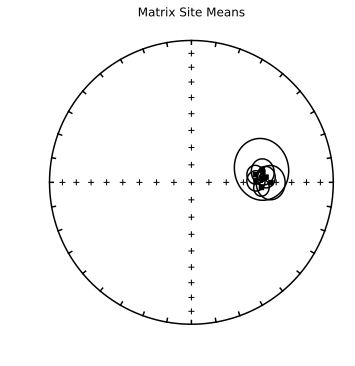

In [62]:
fignum = 13
plt.figure(num=fignum,figsize=(5,5),dpi=200)
ipmag.plot_net(fignum)    
for n in list(site_means_matrix.index):
    ipmag.plot_di_mean(site_means_matrix.loc[n]['dec'],
                      site_means_matrix.loc[n]['inc'],
                      site_means_matrix.loc[n]['a_95'],
                      color='k',marker='s')
plt.title('Matrix Site Means')
# plt.savefig('Code_Output/site_means_matrix_equal-area_no_outliers.svg')
plt.show()

Once again, let's restrict the calculation of the overall mean to sites with $\alpha_{95}$<16.

In [63]:
site_means_matrix_dec=[]
site_means_matrix_inc=[]
site_means_matrix_directions=[]

for n in list(site_means_matrix.index): 
    if site_means_matrix.loc[n]['a_95']<16:
        dec = site_means_matrix.loc[n]['dec']
        inc = site_means_matrix.loc[n]['inc']
        site_means_matrix_dec.append(dec)
        site_means_matrix_inc.append(inc)
        site_means_matrix_directions.append([dec,inc,1.])
        
site_means_matrix_mean = pmag.fisher_mean(site_means_matrix_directions)
site_means_matrix_mean

{'alpha95': 3.2155705333618667,
 'csd': 4.3088183805335873,
 'dec': 87.257210905039727,
 'inc': 48.624300303943357,
 'k': 353.38951537893479,
 'n': 7,
 'r': 6.9830215675935765}

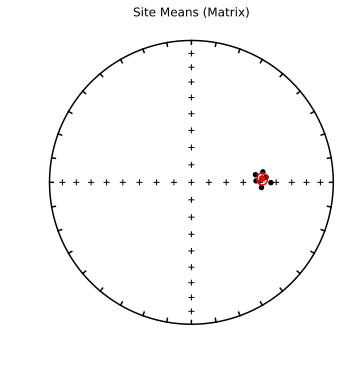

In [64]:
fignum = 14
plt.figure(num=fignum,figsize=(5,5),dpi=200)
ipmag.plot_net(fignum)
ipmag.plot_di(site_means_matrix_dec, site_means_matrix_inc)
ipmag.plot_di_mean(site_means_matrix_mean['dec'],
                  site_means_matrix_mean['inc'],
                  site_means_matrix_mean["alpha95"],
                  color='r',marker='s')
plt.title('Site Means (Matrix)')
# plt.savefig('Code_Output/site_means_matrix_equal-area.svg')
plt.show()

Now let's see if both clasts and matrix yield a common mean. We exclude clast sites **PI2c** and **PI31** from our analysis given the irregularity of the AF data and large $\alpha_{95}$, respectively.

In [65]:
Slate_breccia_dec_clasts=[]
Slate_breccia_inc_clasts=[]
Slate_breccia_DI_clasts=[]

for n in ('PI16','PI22','PI24c'):
    Slate_breccia_dec_clasts.append(site_means_clasts.loc[n]['dec'])
    Slate_breccia_inc_clasts.append(site_means_clasts.loc[n]['inc'])
    Slate_breccia_DI_clasts.append([site_means_clasts.loc[n]['dec'],
                                    site_means_clasts.loc[n]['inc']])

and matrix:

In [66]:
Slate_breccia_dec_matrix=[]
Slate_breccia_inc_matrix=[]
Slate_breccia_DI_matrix=[]

#Use PI15 AF, DeI2 AF, PI26 thermal, PI44 thermal, PI46 thermal
for n in ('PI2m','PI15','DeI2','PI24m','PI26','PI44','PI46','PI47'):
    Slate_breccia_dec_matrix.append(site_means_matrix.loc[n]['dec'])
    Slate_breccia_inc_matrix.append(site_means_matrix.loc[n]['inc'])
    Slate_breccia_DI_matrix.append([site_means_matrix.loc[n]['dec'],
                                    site_means_matrix.loc[n]['inc']])

From this, we can calculate the means for both clasts and matrix for comparison:

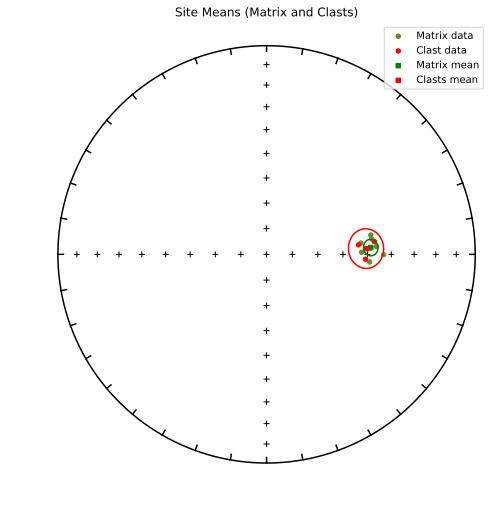

In [67]:
matrix_selected_sites_mean = pmag.fisher_mean(Slate_breccia_DI_matrix)
clasts_selected_sites_mean = pmag.fisher_mean(Slate_breccia_DI_clasts)

fignum = 14
plt.figure(num=fignum,figsize=(7,7),dpi=200)
ipmag.plot_net(fignum)
ipmag.plot_di(Slate_breccia_dec_matrix, Slate_breccia_inc_matrix, color='OliveDrab', label = 'Matrix data')
ipmag.plot_di(Slate_breccia_dec_clasts, Slate_breccia_inc_clasts, color='Red', label = 'Clast data')
ipmag.plot_di_mean(matrix_selected_sites_mean['dec'],
                  matrix_selected_sites_mean['inc'],
                  matrix_selected_sites_mean["alpha95"],
                  color='Green',marker='s', label = 'Matrix mean')
ipmag.plot_di_mean(clasts_selected_sites_mean['dec'],
                  clasts_selected_sites_mean['inc'],
                  clasts_selected_sites_mean["alpha95"],
                  color='Red',marker='s', label = 'Clasts mean')
plt.title('Site Means (Matrix and Clasts)')
plt.legend()
# plt.savefig('Code_Output/matrix_clasts_equal-area.svg')
plt.show()

## Overall Mean

We calculate an overall mean paleomagnetic direction for breccia dikes in the Slate Islands that combines the matrix and clast results. This direction can be considered to be the Slate Islands "impact direction."

In [68]:
selected_sites_mean = pmag.fisher_mean(Slate_breccia_DI_matrix+Slate_breccia_DI_clasts)

In [69]:
selected_sites_mean

{'alpha95': 2.4493063331415144,
 'csd': 4.3390825666803758,
 'dec': 86.384629275498114,
 'inc': 49.076457694734884,
 'k': 348.47707222251483,
 'n': 11,
 'r': 10.9713037074829}

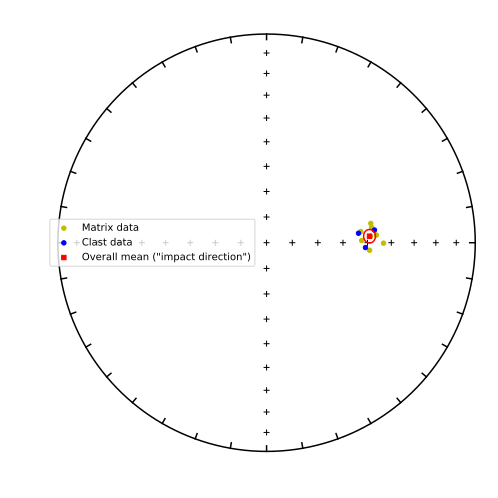

In [70]:
fignum = 30
plt.figure(num=fignum,figsize=(7,7),dpi=200)
ipmag.plot_net(fignum)
#ipmag.plot_di(Slate_breccia_dec_matrix, Slate_breccia_inc_matrix, label='Site means')
#ipmag.plot_di(Slate_breccia_dec_clasts, Slate_breccia_inc_clasts, label='Site means')
ipmag.plot_di(Slate_breccia_dec_matrix, Slate_breccia_inc_matrix, color='y', label = 'Matrix data')
ipmag.plot_di(Slate_breccia_dec_clasts, Slate_breccia_inc_clasts, color='b', label = 'Clast data')
ipmag.plot_di_mean(selected_sites_mean['dec'],
                  selected_sites_mean['inc'],
                  selected_sites_mean["alpha95"],
                  color='r',marker='s',label='Overall mean ("impact direction")')
plt.legend()
# plt.savefig('Code_Output/equal-area_selected_overall_mean.svg')
plt.show()

[Go to top](#Introduction)

# Virtual Geomagnetic Pole Calculations

## VGP calculation with all data

Here we calculate the virtual geomagnetic pole (VGP) of each site.

In [71]:
ipmag.vgp_calc(site_means, dec_tc='dec', inc_tc='inc')
site_means

site_type  site_lat  site_lon demag_type   dec   inc  a_95  \
PI47   breccia dike matrix      48.7     -87.0    Thermal  88.7  52.4   5.5   
DeI2   breccia dike matrix      48.7     273.0    Thermal  90.2  43.3   9.0   
PI2c   breccia dike clasts      48.6     272.9         AF  77.1  69.9  14.6   
PI2m   breccia dike matrix      48.6     272.9    Thermal  79.5  47.9  16.6   
PI15   breccia dike matrix      48.6     273.0    Thermal  81.7  47.8   7.0   
PI16   breccia dike clasts      48.7     273.0    Thermal  84.1  53.5   4.9   
PI22   breccia dike clasts      48.7     273.0    Thermal  83.3  46.8  15.6   
PI24c  breccia dike clasts      48.7     273.0    Thermal  92.8  50.8   9.3   
PI24m  breccia dike matrix      48.7     273.0    Thermal  86.0  46.2   5.7   
PI26   breccia dike matrix      48.6     273.0    Thermal  83.2  52.5   5.1   
PI31   breccia dike clasts      48.6     273.0    Thermal  89.6  31.0  27.2   
PI44   breccia dike matrix      48.7     272.9    Thermal  86.5  48.7   1.9   
PI46   breccia dike matrix      48.7     273.0    Thermal  94.2  49.0   4.7   

        n  kappa        R cong_test_result  paleolatitude    vgp_lat  \
PI47    9   90.0   8.9112             None      32.994182  24.939599   
DeI2    5   73.0   4.9456             None      25.228696  18.549815   
PI2c    9   13.0   8.3992             None      53.799750  43.828671   
PI2m    5   22.0   4.8202             None      28.958430  27.945514   
PI15    5  119.0   4.9664             None      28.873360  26.475001   
PI16   17   55.0  16.7069             None      34.047335  28.478517   
PI22   15    7.0  12.9965             None      28.032887  24.900680   
PI24c   6   53.0   5.9056             None      31.510820  21.417962   
PI24m   6  140.0   5.9644             None      27.537319  22.839605   
PI26    9  103.0   8.9220             None      33.088776  28.366994   
PI31   16    3.0  10.6733             None      16.721861  12.723598   
PI44   12  499.0  11.9780             None      29.645851  23.992766   
PI46   11   96.0  10.8956             None      29.906833  19.431098   

          vgp_lon  vgp_lat_rev  vgp_lon_rev  
PI47   340.629082   -24.939599   160.629082  
DeI2   345.588504   -18.549815   165.588504  
PI2c   325.841478   -43.828671   145.841478  
PI2m   349.775862   -27.945514   169.775862  
PI15   348.474455   -26.475001   168.474455  
PI16   342.659758   -28.478517   162.659758  
PI22   348.126813   -24.900680   168.126813  
PI24c  339.161877   -21.417962   159.161877  
PI24m  346.699576   -22.839605   166.699576  
PI26   343.989806   -28.366994   163.989806  
PI31   352.051585   -12.723598   172.051585  
PI44   344.617234   -23.992766   164.617234  
PI46   339.451746   -19.431098   159.451746

First, let's calculate a mean pole for all data:

/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


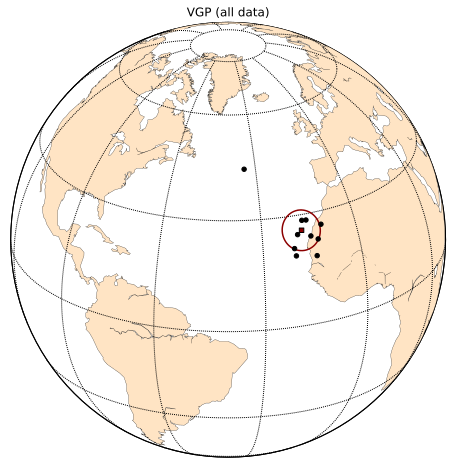

In [72]:
Slate_breccia_VGPs=[]
Slate_breccia_Plong=[]
Slate_breccia_Plat=[]

for n in range(0,len(site_means)):
    if site_means['a_95'][n]<15:
        Plong,Plat=site_means['vgp_lon'][n],site_means['vgp_lat'][n]
        Slate_breccia_VGPs.append([Plong,Plat,1.])
        Slate_breccia_Plong.append(Plong)
        Slate_breccia_Plat.append(Plat)
    
Breccia_pole_mean=pmag.fisher_mean(Slate_breccia_VGPs)
    
plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho',lat_0=25,lon_0=320,
            resolution='c',area_thresh=50000)
m.drawcoastlines(linewidth=0.25)
m.fillcontinents(color='bisque',lake_color='white',zorder=1)
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))

ipmag.plot_vgp(m,Slate_breccia_Plong,Slate_breccia_Plat)
ipmag.plot_pole(m,Breccia_pole_mean['dec'],Breccia_pole_mean['inc'],
               Breccia_pole_mean['alpha95'],label='Slate breccia mean',
               marker='s',color='DarkRed')
# plt.savefig('Code_output/VGP_all_data.pdf')
plt.title('VGP (all data)')
plt.show()

In [73]:
ipmag.vgp_calc(site_means_clasts, dec_tc='dec', inc_tc='inc')
site_means_clasts

site_type  site_lat  site_lon demag_type   dec   inc  a_95  \
PI2c   breccia dike clasts      48.6     272.9         AF  77.1  69.9  14.6   
PI16   breccia dike clasts      48.7     273.0    Thermal  84.1  53.5   4.9   
PI22   breccia dike clasts      48.7     273.0    Thermal  83.3  46.8  15.6   
PI24c  breccia dike clasts      48.7     273.0    Thermal  92.8  50.8   9.3   
PI31   breccia dike clasts      48.6     273.0    Thermal  89.6  31.0  27.2   

        n  kappa        R cong_test_result  paleolatitude    vgp_lat  \
PI2c    9   13.0   8.3992             None      53.799750  43.828671   
PI16   17   55.0  16.7069             None      34.047335  28.478517   
PI22   15    7.0  12.9965             None      28.032887  24.900680   
PI24c   6   53.0   5.9056             None      31.510820  21.417962   
PI31   16    3.0  10.6733             None      16.721861  12.723598   

          vgp_lon  vgp_lat_rev  vgp_lon_rev  
PI2c   325.841478   -43.828671   145.841478  
PI16   342.659758   -28.478517   162.659758  
PI22   348.126813   -24.900680   168.126813  
PI24c  339.161877   -21.417962   159.161877  
PI31   352.051585   -12.723598   172.051585

From the clast sites above, we select sites **PI16**, **PI22**, and **PI24c** based on $\alpha_{95}$ < 16.0 and reliability of demagnetization data (irregular AF demagnetization data of PI2c was rejected for the final analysis). 

In [74]:
Slate_breccia_VGPs_clasts=[]
Slate_breccia_Plong_clasts=[]
Slate_breccia_Plat_clasts=[]
Slate_breccia_dec_clasts=[]
Slate_breccia_inc_clasts=[]
Slate_breccia_DI_clasts=[]

#Using VGPs where DI_alpha95<16
#Use PI16 thermal, PI22 thermal, PI24 thermal
for n in ('PI16','PI22','PI24c'):
    Plong = site_means_clasts['vgp_lon'][n]
    Plat = site_means_clasts['vgp_lat'][n]
    Slate_breccia_VGPs_clasts.append([Plong,Plat,1.])
    Slate_breccia_Plong_clasts.append(Plong)
    Slate_breccia_Plat_clasts.append(Plat)
    Slate_breccia_dec_clasts.append(site_means_clasts['dec'][n])
    Slate_breccia_inc_clasts.append(site_means_clasts['inc'][n])
    Slate_breccia_DI_clasts.append([site_means_clasts['dec'][n],
                                    site_means_clasts['inc'][n]])
    
Breccia_pole_mean_clasts=pmag.fisher_mean(Slate_breccia_VGPs_clasts)

In [75]:
ipmag.vgp_calc(site_means_matrix, dec_tc='dec', inc_tc='inc')
# site_means_matrix.to_latex('latex_tables/site_means_matrix.txt')
site_means_matrix

site_type  site_lat  site_lon demag_type   dec   inc  a_95  \
PI47   breccia dike matrix      48.7     -87.0    Thermal  88.7  52.4   5.5   
DeI2   breccia dike matrix      48.7     273.0    Thermal  90.2  43.3   9.0   
PI2m   breccia dike matrix      48.6     272.9    Thermal  79.5  47.9  16.6   
PI15   breccia dike matrix      48.6     273.0    Thermal  81.7  47.8   7.0   
PI24m  breccia dike matrix      48.7     273.0    Thermal  86.0  46.2   5.7   
PI26   breccia dike matrix      48.6     273.0    Thermal  83.2  52.5   5.1   
PI44   breccia dike matrix      48.7     272.9    Thermal  86.5  48.7   1.9   
PI46   breccia dike matrix      48.7     273.0    Thermal  94.2  49.0   4.7   

        n  kappa        R cong_test_result  paleolatitude    vgp_lat  \
PI47    9   90.0   8.9112             None      32.994182  24.939599   
DeI2    5   73.0   4.9456             None      25.228696  18.549815   
PI2m    5   22.0   4.8202             None      28.958430  27.945514   
PI15    5  119.0   4.9664             None      28.873360  26.475001   
PI24m   6  140.0   5.9644             None      27.537319  22.839605   
PI26    9  103.0   8.9220             None      33.088776  28.366994   
PI44   12  499.0  11.9780             None      29.645851  23.992766   
PI46   11   96.0  10.8956             None      29.906833  19.431098   

          vgp_lon  vgp_lat_rev  vgp_lon_rev  
PI47   340.629082   -24.939599   160.629082  
DeI2   345.588504   -18.549815   165.588504  
PI2m   349.775862   -27.945514   169.775862  
PI15   348.474455   -26.475001   168.474455  
PI24m  346.699576   -22.839605   166.699576  
PI26   343.989806   -28.366994   163.989806  
PI44   344.617234   -23.992766   164.617234  
PI46   339.451746   -19.431098   159.451746

All matrix sites above were selected for the final VGP analysis. 

In [76]:
Slate_breccia_VGPs_matrix=[]
Slate_breccia_Plong_matrix=[]
Slate_breccia_Plat_matrix=[]
Slate_breccia_dec_matrix=[]
Slate_breccia_inc_matrix=[]
Slate_breccia_DI_matrix=[]

#Using VGPs where DI_alpha95<10 and using either AF or thermal for single site
#based on lower DI_alpha95

for n in ('PI2m','PI15','DeI2','PI24m','PI26','PI44','PI46','PI47'):
    Plong,Plat=site_means_matrix['vgp_lon'][n],site_means_matrix['vgp_lat'][n]
    Slate_breccia_VGPs_matrix.append([Plong,Plat,1.])
    Slate_breccia_Plong_matrix.append(Plong)
    Slate_breccia_Plat_matrix.append(Plat)
    Slate_breccia_dec_matrix.append(site_means_matrix['dec'][n])
    Slate_breccia_inc_matrix.append(site_means_matrix['inc'][n])
    Slate_breccia_DI_matrix.append([site_means_matrix['dec'][n],
                                    site_means_matrix['inc'][n]])
    
Breccia_pole_mean_matrix=pmag.fisher_mean(Slate_breccia_VGPs_matrix)

[Go to top](#Introduction)

## Mean Pole

Now let's calculate the final virtual geomagnetic pole for our selected data. Then, let's compare this VGP to the corresponding paleopole of the Laurentian APWP using data compiled by Torsvik (2012). 

In [77]:
Slate_breccia_VGPs_all = Slate_breccia_VGPs_clasts + Slate_breccia_VGPs_matrix
Slate_breccia_Plong_all = Slate_breccia_Plong_matrix + Slate_breccia_Plong_clasts
Slate_breccia_Plat_all = Slate_breccia_Plat_matrix + Slate_breccia_Plat_clasts
Slate_breccia_VGPs_all_mean = pmag.fisher_mean(Slate_breccia_VGPs_all)
Slate_breccia_VGPs_all_mean

{'alpha95': 2.7221302583356581,
 'csd': 4.8208406069443672,
 'dec': 344.43709458172481,
 'inc': 24.344490277837423,
 'k': 282.30884990783176,
 'n': 11,
 'r': 10.964577801924152}

In [78]:
Slate_breccia_VGPs_all

[[342.6597578995881, 28.478517393057071, 1.0],
 [348.12681294861392, 24.900679973982339, 1.0],
 [339.16187730323963, 21.41796247221362, 1.0],
 [349.77586230694658, 27.945513904950364, 1.0],
 [348.47445515872732, 26.47500062457603, 1.0],
 [345.58850397383299, 18.5498148685672, 1.0],
 [346.69957626235396, 22.839604966214189, 1.0],
 [343.98980574310781, 28.366994404340627, 1.0],
 [344.61723408807387, 23.9927664226059, 1.0],
 [339.45174629362003, 19.431097632218133, 1.0],
 [340.62908212720566, 24.939599070070557, 1.0]]

/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


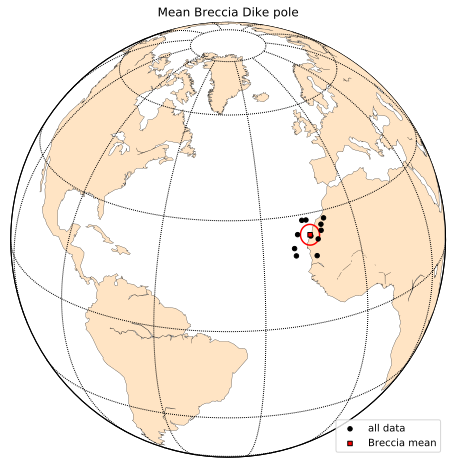

In [79]:
plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho',lat_0=25,lon_0=320,
            resolution='c',area_thresh=50000)
m.drawcoastlines(linewidth=0.25)
m.fillcontinents(color='bisque',lake_color='white',zorder=1)
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))

ipmag.plot_vgp(m,Slate_breccia_Plong_all,
              Slate_breccia_Plat_all,label='all data',color='Black')
ipmag.plot_pole(m,Slate_breccia_VGPs_all_mean['dec'],
               Slate_breccia_VGPs_all_mean['inc'],
               Slate_breccia_VGPs_all_mean['alpha95'],
               label='Breccia mean',marker='s',color='Red')
plt.legend(loc=4)
# plt.savefig('Code_output/site_VGPs.pdf')
plt.title('Mean Breccia Dike pole')
plt.show()

[Go to top](#Introduction)

## Comparison to Laurentia APWP

First, let's compare our VGP to the Phanerozoic APWP compiled by Torsvik (2012).

In [80]:
Laurentia_Pole_Compilation = pd.read_csv('APWP analysis/Laurentia_Pole_Compilation.csv')
Laurentia_Pole_Compilation

Q   A95  Com                               Formation   Lat    Lon  CLat  \
0   5   3.9  NaN                       Dunkard Formation -44.1  301.5 -41.5   
1   5   2.1  NaN                    Laborcita  Formation -42.1  312.1 -43.0   
2   5   3.4    #                     Wescogame Formation -44.1  303.9 -46.3   
3   6   3.1    I                      Glenshaw Formation -28.6  299.9 -28.6   
4   5   1.8  NaN                Lower  Casper  Formation -45.7  308.6 -50.5   
5   5   6.0  NaN                        Riversdale Group -36.0  302.0 -30.2   
6   7   7.7    I          Shepody Formation, Nova Scotia -27.2  298.3 -27.2   
7   6   8.3    I                             Mauch Chunk -22.6  294.4 -22.6   
8   7  15.3    I       Maringouin Formation, Nova Scotia -27.9  297.2 -27.9   
9   4   6.5  NaN  New Brunswick volcanics I and  redbeds -19.5  315.8 -19.5   
10  6   8.0  NaN                 Jeffreys Village Member -27.0  311.0 -17.8   
11  7   9.0  I__                     Deer Lake Formation -18.6  304.2 -18.6   
12  3  16.0  NaN                Catskill Formation South -27.4  303.0 -16.6   
13  4   9.0  NaN                       Andreas red  beds -13.0  285.0   1.5   
14  7   5.3  NaN                             Wabash Reef -17.0  305.0 -17.0   
15  6   5.8  NaN                     Rose Hill Formation -19.1  308.3 -19.1   
16  4   7.3  NaN                 Ringgold  Gap sediments -24.0  326.6 -16.9   
17  4   3.9  NaN         Tablehead Group  limestone Mean -13.4  329.3 -13.4   
18  4   4.3  NaN            St. George  Group  limestone -17.5  332.4 -17.5   
19  6  11.9  NaN                         Oneota Dolomite -10.3  346.5 -10.3   
20  5   8.5  NaN                Moore  Hollow  sediments   0.6  343.0   3.1   
21  5   9.7  NaN                            Morgan Creek -10.6  338.0  -8.4   
22  5   9.0  NaN                             Point  Peak  -5.2  345.8  -4.7   
23  5   7.1  NaN                    Taum  Sauk limestone   3.4  355.1   3.4   
24  6   4.3  NaN                          Royer Dolomite -12.6  337.3 -12.6   
25  6  10.0  NaN                      Florida  Mountains   5.4  348.7   5.4   
26  5   3.3  NaN                       Tapeats Sandstone  -0.6  341.1  -1.7   
27  5   6.2  NaN    Mont  Rigaud  and  Chatham_Grenville  11.9    4.5  11.9   

     CLon  RLat  RLon               EULER  Age  \
0   300.4 -38.0  43.0  (63.2/_ 13.9/79.9)  300   
1   313.4 -32.7  52.9  (63.2/_ 13.9/79.9)  301   
2   306.8 -38.2  51.4  (63.2/_ 13.9/79.9)  301   
3   299.9 -28.6  32.4  (63.2/_ 13.9/79.9)  303   
4   314.6 -37.6  59.8  (63.2/_ 13.9/79.9)  303   
5   301.5 -29.0  34.8  (63.2/_ 13.9/79.9)  310   
6   298.3 -28.4  30.2  (63.2/_ 13.9/79.9)  317   
7   294.4 -26.9  23.8  (63.2/_ 13.9/79.9)  320   
8   297.2 -29.5  29.8  (63.2/_ 13.9/79.9)  322   
9   315.8 -12.6  39.2  (63.2/_ 13.9/79.9)  330   
10  309.8   NaN   NaN                 NaN  333   
11  304.2   NaN   NaN                 NaN  335   
12  299.6   NaN   NaN                 NaN  370   
13  284.8   NaN   NaN                 NaN  415   
14  305.0   NaN   NaN                 NaN  420   
15  308.3   NaN   NaN                 NaN  425   
16  321.7   NaN   NaN                 NaN  438   
17  329.3   NaN   NaN                 NaN  470   
18  332.4   NaN   NaN                 NaN  480   
19  346.5   NaN   NaN                 NaN  490   
20  338.9   NaN   NaN                 NaN  495   
21  334.6   NaN   NaN                 NaN  495   
22  345.0   NaN   NaN                 NaN  495   
23  355.1   NaN   NaN                 NaN  500   
24  337.3   NaN   NaN                 NaN  500   
25  348.7   NaN   NaN                 NaN  503   
26  342.6   NaN   NaN                 NaN  508   
27    4.5   NaN   NaN                 NaN  532   

                GPDB RefNo/Reference  
0                             302, T  
1                           1311,  T  
2                           1311,  T  
3                      Kodama (2009)  
4                           1455,  T  
5                          

We use the actual paleopoles (no running mean) for this comparison. Then, let's add breccia dike data from Halls (1979) for comparison. We then add a color code to indicate the age of each paleopole. We are focused on comparision with ~440 Ma paleopole, as this is the age of the Slate Islands impact inferred from Ar-Ar data (Dressler, 1999).

/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


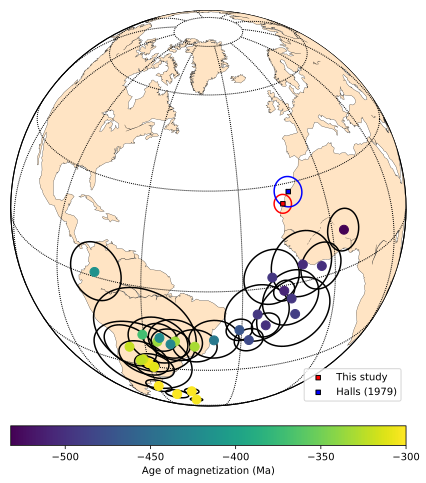

In [82]:
plt.figure(figsize=(8, 8))
pmap = Basemap(projection='ortho',lat_0=25,lon_0=320,
               resolution='c',area_thresh=50000)
pmap.drawcoastlines(linewidth=0.25)
pmap.fillcontinents(color='bisque',lake_color='white',zorder=1)
pmap.drawmapboundary(fill_color='white')
pmap.drawmeridians(np.arange(0,360,30))
pmap.drawparallels(np.arange(-90,90,30))

ipmag.plot_pole(pmap,Slate_breccia_VGPs_all_mean['dec'],
               Slate_breccia_VGPs_all_mean['inc'],
               Slate_breccia_VGPs_all_mean['alpha95'],
               label='This study',
               marker='s',color='Red')

#Halls data:
ipmag.plot_pole(pmap,347.1,27.5,4.4,label='Halls (1979)',
               marker='s',color='Blue')

for n in range (0, len(Laurentia_Pole_Compilation)):
     m = ipmag.plot_pole_colorbar(pmap, Laurentia_Pole_Compilation['CLon'][n],
                                  Laurentia_Pole_Compilation['CLat'][n],
                                  Laurentia_Pole_Compilation['A95'][n],
                                  -Laurentia_Pole_Compilation['Age'][n],
                                  -532,
                                  -300,
                                  markersize=80, color="k", alpha=1)

pmap.colorbar(m,location='bottom',pad="5%",label='Age of magnetization (Ma)')
plt.legend()
plt.show()

In [84]:
print("The distance between the Slate Island VGP and the ca. 490 Ma Oneota Dolomite pole is:")
print(pmag.angle([Slate_breccia_VGPs_all_mean['dec'],
               Slate_breccia_VGPs_all_mean['inc']],
          [Laurentia_Pole_Compilation['CLon'][19],
                                  Laurentia_Pole_Compilation['CLat'][19]]))
print("The distance between the Slate Island VGP and the ca. 438 Ma Ringgold Gap pole is:")
print(pmag.angle([Slate_breccia_VGPs_all_mean['dec'],
               Slate_breccia_VGPs_all_mean['inc']],
          [Laurentia_Pole_Compilation['CLon'][16],
                                  Laurentia_Pole_Compilation['CLat'][16]]))

The distance between the Slate Island VGP and the ca. 490 Ma Oneota Dolomite pole is:
[ 34.7029994]
The distance between the Slate Island VGP and the ca. 438 Ma Ringgold Gap pole is:
[ 46.83051059]


[Go to top](#Introduction)

We see that there is an ~47&deg; difference between the Slate Islands VGP and the Silurian paleopole that most closely corresponds in age to the 440 Ma age assigned to the Slate Islands impact through Ar-Ar dating of pseudotachylite impact melt (Dressler et al., 1999). It is ~35&deg; from the ca. 490 Ma Oneota Dolomite pole.

Halls (1979) noted the similiarity of the Slate Islands VGP to the late Meso- to Neoproterozoic "Grenville Loop" of the Laurentia APWP. Given the quickly-acquired nature of magnetizations in the Slate Islands, this VGP cannot account for secular variation and therefore may correspond to a wide range of well-averaged paleopoles within the APWP. Additionally, the non-linear "loop" nature of this section of the APWP serves to cluster poles of a wide age range within a single location.  Because of this, Halls (1979) uses the Slate Islands VGP to date the impact but can only do so within a very general timeframe of 500-900 Ma.

Here we compare the Slate Islands VGP (reversed polarity) to the Proterozoic APWP of Laurentia as compiled by Swanson-Hysell et al. (2012).

In [85]:
Laurentia_Prot_poles = pd.read_csv('APWP analysis/Laurentia_Proterozoic_APWP.csv')
Laurentia_Prot_poles_info = pd.read_csv('APWP analysis/Swanson-Hysell2012_Prot_APWP.csv')
Laurentia_Prot_poles_info

pole    abbr  Lat (N)  Long (E)   A95  \
0                      Mackenzie Dykes    L-MD      4.0     190.0   5.0   
1                        Sudbury Dykes    L-SD     -3.0     192.0   3.0   
2                        Abitibi Dykes    L-AD     43.0     209.0  14.0   
3                          Logan sills    L-LS     49.0     220.0   4.0   
4                      Osler Volcanics    L-OV     43.7     196.3   7.6   
5   North Shore Volcanic Group (upper)  L-NSVG     36.7     182.3   3.6   
6               Portage Lake Volcanics    L-PL     27.3     178.3   4.8   
7                     Lake Shore Traps   L-LST     22.2     180.8   5.0   
8                       Nonesuch Shale    L-NS      7.7     178.2   5.9   
9                      Freda Sandstone    L-FS      3.7     179.1   4.8   
10               Jacobsville Sandstone    L-JS     -9.3     183.6   4.7   
11               Chequamegon Sandstone    L-CS    -12.3     177.7   4.6   
12               Haliburton Intrusives    L-HI    -32.6     141.9   6.3   
13                 Nankoweap Formation    L-NF    -10.0     163.0   4.9   
14           Gunbarrel dykes and sills    L-GB      9.2     138.7   9.0   
15                Uinta Mountain Group    L-UM      0.8     161.3   4.6   
16                   Galeros Formation    L-GF     -2.1     163.0   6.0   
17                   Kwagunt Formation    L-KF     18.2     166.0   7.0   
18           Franklin Event Grand Mean  L-FLIP      8.4     163.8   2.8   
19                    Long Range Dykes   L-LRD     19.0     355.3  17.4   

                                          Age (Ma)  \
0                                             1267   
1                                        1235+7/-3   
2                                             1141   
3                                             1109   
4                                             1105   
5                                   1098.4, 1096.6   
6                                             1095   
7                                             1087   
8                                            <1087   
9   <L-NS (deposited during active rift volcanism)   
10                                          < L-FS   
11                              < L-FS, upper L-JS   
12                                            1015   
13                                         <942 Ma   
14                                         782-776   
15                                         780-742   
16                                             804   
17                                  older than 742   
18                                         721-712   
19                                             615   

                        Reference  
0         Buchan and Halls (1990)  
1        Palmer and others (1977)  
2         Ernst and Buchan (1993)  
3        Buchan and others (2000)  
4                    Halls (1974)  
5         Tauxe and Kodama (2009)  
6          Hnat and others (2006)  
7           Diehl and Haig (1994)  
8         Henry and others (1977)  
9         Henry and others (1977)  
10       Roy and Robertson (1978)  
11  McCabe and Van der Voo (1983)  
12      Warnock and others (2000)  
13         Weil and others (2003)  
14       Harlan and others (2008)  
15         Weil and others (2006)  
16         Weil and others (2004)  
17         Weil and others (2004)  
18     Denyszyn and others (2009)  
19       Murthy and others (1992)

/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/lukefairchild765/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


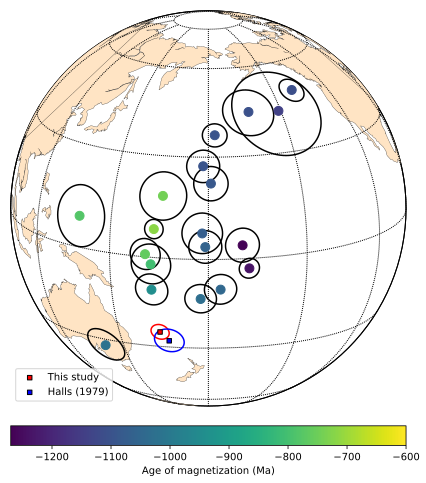

In [87]:
plt.figure(figsize=(8, 8))
pmap = Basemap(projection='ortho',lat_0=15,lon_0=180,
               resolution='c',area_thresh=50000)
pmap.drawcoastlines(linewidth=0.25)
pmap.fillcontinents(color='bisque',lake_color='white',zorder=1)
pmap.drawmapboundary(fill_color='white')
pmap.drawmeridians(np.arange(0,360,30))
pmap.drawparallels(np.arange(-90,90,30))

ipmag.plot_pole(pmap,(Slate_breccia_VGPs_all_mean['dec']+180)%360,
               -Slate_breccia_VGPs_all_mean['inc'],
               Slate_breccia_VGPs_all_mean['alpha95'],
               label='This study',
               marker='s',color='Red')

#Halls data:
ipmag.plot_pole(pmap,347.1-180,-27.5,4.4,label='Halls (1979)',
               marker='s',color='Blue')

for n in range (0, len(Laurentia_Prot_poles)):
     m = ipmag.plot_pole_colorbar(pmap, Laurentia_Prot_poles['Plong'][n],
                                  Laurentia_Prot_poles['Plat'][n],
                                  Laurentia_Prot_poles['A95'][n],
                                  -Laurentia_Prot_poles['Age'][n],-1270,-600,markersize=80, color="k", alpha=1)

pmap.colorbar(m,location='bottom',pad="5%",label='Age of magnetization (Ma)')
plt.legend()
#plt.savefig('Code_output/site_VGP_with_Laurentia_Pole_Compilation_colorbar.pdf')
plt.show()

As seen above, the Slate Islands VGP accords better with the late Mesoproterozoic section of the Laurentia APWP than the Paleozoic (Silurian) section, despite radiometric evidence for a ~440 Ma impact age (Dressler, 1999).

Next, we investigate the likelihood of the 50.6&deg; geomagnetic excursion observed in our Slate Islands VGP/Paleozoic APWP comparison. 

## Probability of a large deviation from geomagnetic north by a VGP

The statistical secular variation model TK03 can be used to simulate secular variation with random draws being taken from the model. The function is set up to return directions so they are then recalculated as poles. Using this model, we can estimate the probability of there being a single VGP that is as far from the APWP path as the Slate Islands pole is from the Silurian path. 

Distance from the Slate Islands to the 438 Ma Rose Hill pole can be calculated (colatitude) and used to determine the paleolatitude of the Slate Islands as constrained by the Rose Hill pole. This paleolatitude is then used for the latitude at which the random draw from the TK03 model are taken.

In [89]:
Rose_Hill_Plat = -19.1 
Rose_Hill_Plong = 308.3
Rose_Hill = (Rose_Hill_Plong, Rose_Hill_Plat)

Slate_Lat = 48.6
Slate_Long = -87.0
Slate = (Slate_Long, Slate_Lat)

plat = 90 - pmag.angle(Rose_Hill, Slate)
print(plat[0])

15.3407768768


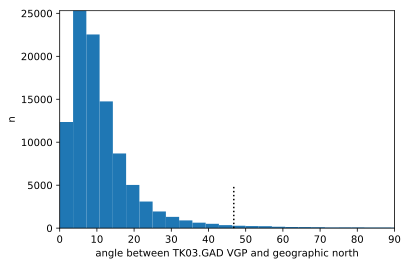

In [90]:
VGPs = ipmag.tk03(n=100000,lat=15) #set at 100,000 this takes a long time to run
VGP_dataframe = pd.DataFrame(VGPs,columns=['dec_tc','inc_tc','int'])
VGP_dataframe['site_lat'] = pd.Series(np.random.uniform(plat,plat,size=len(VGPs)))
VGP_dataframe['site_lon'] = pd.Series(np.random.uniform(0,0,size=len(VGPs)))

ipmag.vgp_calc(VGP_dataframe)    

greater_10 = []
greater_20 = []
greater_30 = []
greater_40 = []
greater_50 = []
angles = []
for n in range(len(VGP_dataframe)):
    true_north = (0,90)
    vgp = (VGP_dataframe['vgp_lon'][n],VGP_dataframe['vgp_lat'][n])
    angle = pmag.angle(true_north,vgp)
    angles.append(angle[0])
    if angle > 10:
        greater_10.append(angle[0])
    if angle > 20:
        greater_20.append(angle[0])
    if angle > 30:
        greater_30.append(angle[0])
    if angle > 40:
        greater_40.append(angle[0])
    if angle > 50:
        greater_50.append(angle[0])
    
n, bins, patches = plt.hist(angles, bins=50)
plt.vlines(46.8,0,5000,linestyles='dotted')
plt.xlim(0,90)
plt.ylim(0,n.max())
plt.xlabel('angle between TK03.GAD VGP and geographic north')
plt.ylabel('n')
plt.show()

In [91]:
percent_gt_30 = float(len(greater_30))/float(len(angles))*100
percent_gt_40 = float(len(greater_40))/float(len(angles))*100
print("The percent of VGPs >30º away from mean pole in the TK03 model is:")
print(percent_gt_30)
print("The percent of VGPs >40º away from mean pole in the TK03 model is:")
print(percent_gt_40)

The percent of VGPs >30º away from mean pole in the TK03 model is:
5.686999999999999
The percent of VGPs >40º away from mean pole in the TK03 model is:
3.3160000000000003
